In [1]:
import os
from joblib import Parallel, delayed
import time
import numpy as np
import pickle
import pylab as pl


In [2]:
time.sleep(80)

In [3]:
total_count = 48


In [4]:


def getTimesThputs(file):
    f = open(file, "r")
    data = f.readlines() 
    times = []
    thputs = []
    latencies = []
    for line in data:
        if not line.startswith('--') and 'current ops/sec; [UPDATE AverageLatency' in line:

#         print(line)
            times.append(line.split('sec:')[0].strip())
            thputs.append(line.split(';')[1].split('current')[0].strip())
            latencies.append(line.split('=')[1].split(']')[0].strip())
            
            print(line,latencies[-1],thputs[-1],times[-1])

    return np.array(times).astype(float), np.array(thputs).astype(float), np.array(latencies).astype(float)/1e6  






def getTimeThps(file, flag):
    
    f = open(file, "r")
    data = f.readlines() 

    times = []
    thputs = []
    for line in data:
        if 'throughput[ops/s]' in line:
            lineData = (line[13+line.find('max[ops/s])>'):-2])
            print(lineData)

            times.append(lineData.split('|')[0])
            thputs.append(lineData.split('|')[-2])
    if (flag): 
        times.append(float(times[-1])+abs(float(times[-1]) - float(times[-2]) ))
        thputs.append(0)
        
    return np.array(times).astype(float), np.array(thputs).astype(float) 

In [5]:
# os.system("aws --region ap-south-1 ec2 describe-instances  --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances --filter Name=instance-type,Values=t2.small --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")



# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PrivateIpAddress]' --output text > all_internal_ips")

# os.system("aws --region ap-south-1 ec2 describe-instances  --query 'Reservations[*].Instances[*].[PublicIpAddress]' --output text > all_external_ips")

In [6]:
with open('all_external_ips') as f:
    lines = f.read().splitlines()


lines = [x for x in lines if x!='None']
lines, len(lines)

(['65.2.152.117',
  '43.205.142.92',
  '13.126.215.64',
  '15.206.170.223',
  '43.205.232.251',
  '65.2.143.162',
  '43.205.146.187',
  '13.126.255.193',
  '65.0.168.237',
  '13.233.31.222',
  '65.1.132.61',
  '3.110.131.188',
  '65.2.178.212',
  '13.232.128.43',
  '13.233.128.155',
  '3.110.187.29',
  '3.109.139.239',
  '13.233.106.205',
  '3.110.169.175',
  '13.126.50.194',
  '65.2.33.73',
  '13.127.135.37',
  '35.154.188.112',
  '65.2.144.174',
  '3.110.178.211',
  '13.127.204.126',
  '15.206.91.92',
  '13.233.184.59',
  '13.233.254.172',
  '13.233.125.205',
  '13.127.210.177',
  '52.66.42.244',
  '13.234.32.196',
  '13.235.0.5',
  '52.66.207.200',
  '13.233.53.174',
  '13.233.34.70',
  '65.2.140.137',
  '13.233.28.213',
  '35.154.33.200',
  '13.233.21.55',
  '15.206.93.8',
  '15.207.51.134',
  '13.233.223.149',
  '13.235.132.190',
  '35.154.68.156',
  '13.126.88.177',
  '3.108.67.128',
  '3.109.182.29',
  '65.1.85.132',
  '13.232.70.1',
  '65.0.30.133',
  '52.66.4.191',
  '3.110.18

In [7]:
for ip in lines:
    if ip!='None':
        current = (ip.split('.'))

        print('ssh -i "FinalKeys.pem" ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com')

ssh -i "FinalKeys.pem" ubuntu@ec2-65-2-152-117.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-43-205-142-92.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-126-215-64.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-15-206-170-223.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-43-205-232-251.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-2-143-162.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-43-205-146-187.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-126-255-193.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-0-168-237.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-13-233-31-222.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-1-132-61.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-3-110-131-188.us-west-1.compute.amazonaws.com
ssh -i "FinalKeys.pem" ubuntu@ec2-65-2-17

In [8]:
## Set number of clusters

nclusters = 0

for folder in os.listdir('.'):
    if 'config' in folder and folder!='config':
        nclusters = nclusters + 1
        
        
print(nclusters)




nreplicas = int(total_count/nclusters)
nodeIps = lines[:nclusters* nreplicas]

nclients = nclusters

# no_cluster_yet_nodes = lines[nclusters* nreplicas:-(nclusters)]
no_cluster_yet_nodes = lines[nclusters* nreplicas:-nclients]



# clientIps = lines[-(nclusters):]
clientIps = lines[-nclients:]



clientIps, no_cluster_yet_nodes

8


(['3.109.182.29',
  '65.1.85.132',
  '13.232.70.1',
  '65.0.30.133',
  '52.66.4.191',
  '3.110.187.197',
  '65.0.168.244',
  '13.235.242.255'],
 [])

In [9]:
## Functions

def setup(i):

    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:commands.sh'
        
        print(command)
        os.system(command)
        
def initialize(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'echo 3108 | sudo -S ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t " sudo sh commands.sh; cd BftSmart_Final/simul_latency/; sudo sh node_'+str(i)+'.sh"'
        
        
        os.system(command)
        
        
def git_clone(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t " sudo git clone https://github.com/tmane002/BftSmart_Final.git"'
        
        
        os.system(command)
        
def git_pull(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/BftSmart_Final; cd BftSmart_Final; sudo git pull"'
        
        
        os.system(command)
        
def compile_job(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo ./gradlew installDist"'
        
        
        os.system(command)

        
        
def clean_job(i):
    ip = lines[i]
    
    rm_command = 'sudo rm config/currentView; '
    for iter_ in range(nclusters):
        rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; cd BftSmart_Final; '+rm_command+'"'
        
        
        os.system(command)
        
        
def clean_all(i):
    ip = lines[i]
    
    rm_command = 'sudo rm -r BftSmart_Final; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
        os.system(command)
        
def run_server_node(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)
        
        
        
    if ip!='None' and( ip in no_cluster_yet_nodes):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        os.system(command)        
#         print(command)

def check_node(i):
    ip = lines[i]
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
        os.system(command)
#         print(command)


def run_basic_client(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
#     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
        current = (ip.split('.'))
        
#         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
        os.system(command)


def kill_java(i):
    ip = lines[i]
    
    if ip!='None':
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)
        
        
        
def kill_clients(i):
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        current = (ip.split('.'))
        command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo killall java; sudo killall nohup"'
        
        
        os.system(command)

def run_server_node_check(i):
    ip = lines[i]
#     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
    if ip!='None' and( ip in nodeIps):
        
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com -T "cd BftSmart_Final; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
        print(command)
        
        

# for i in range(len(lines)):
#     run_server_node_check(i)

def run_basic_client_check(i):
    cmd_arg = ''
    
    ip = lines[i]
    if ip!='None' and ip in clientIps:
        
        for iter__ in range(len(clientIps)):
            if ip==clientIps[iter__]:
                cmd_arg = iter__
                
                
        
#         print(i, cmd_arg)
            
        current = (ip.split('.'))
        command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com "cd BftSmart_Final; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
        print(command)

In [10]:
# for i in range(len(lines)):
#     run_basic_client_check(i)
    

# def setup(i):

#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'commands.sh'+' ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com:commands.sh'
        
        
#         os.system(command)
        
# def initialize(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "sudo sh commands.sh"'
        
        
#         os.system(command)
        
        
# def git_clone(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t " sudo git clone https://tmane002@bitbucket.org/tmane002/BftSmart_Final.git"'
        
        
#         os.system(command)
        
# def git_pull(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -t "git config --global --add safe.directory /home/ubuntu/bftsmartt; cd bftsmartt; sudo git pull"'
        
        
#         os.system(command)
        
# def compile_job(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo ./gradlew installDist"'
        
        
#         os.system(command)

        
        
# def clean_job(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm config/currentView; '
#     for iter_ in range(nclusters):
#         rm_command = rm_command + 'sudo rm config'+str(iter_)+'/currentView; '
        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; cd bftsmartt; '+rm_command+'"'
        
        
#         os.system(command)
        
        
# def clean_all(i):
#     ip = lines[i]
    
#     rm_command = 'sudo rm -r bftsmartt; sudo rm nohup.out;sudo rm nohup_client.out;'

        
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "sudo rm nohup.out; '+rm_command+'"'
        
        
#         os.system(command)
        
# def run_server_node(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)
        
        
        
#     if ip!='None' and( ip in no_cluster_yet_nodes):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         os.system(command)        
# #         print(command)

# def check_node(i):
#     ip = lines[i]
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -f -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "tail -n 1000 nohup.out"'
        
        
#         os.system(command)
# #         print(command)


# def run_basic_client(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
# #     if ip!='None' and ip in nodeIps[1:1+len(clientIps)]:
        
#         current = (ip.split('.'))
        
# #         cmd_arg = nodeIps[1:1+len(clientIps)].index(ip)
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup_client.out 2>&1 &"'

        
#         os.system(command)


# def kill_java(i):
#     ip = lines[i]
    
#     if ip!='None':
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)
        
        
        
# def kill_clients(i):
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
#         current = (ip.split('.'))
#         command = 'ssh -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo killall java; sudo killall nohup"'
        
        
#         os.system(command)

# def run_server_node_check(i):
#     ip = lines[i]
# #     if ip!='None' and( ip in nodeIps or ip in no_cluster_yet_nodes):
#     if ip!='None' and( ip in nodeIps):
        
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com -T "cd bftsmartt; sudo nohup ./runscripts/startReplicaYCSB.sh '+str(i)+' >../nohup.out 2>&1 &"'
        
        
#         print(command)
        
        

# # for i in range(len(lines)):
# #     run_server_node_check(i)

# def run_basic_client_check(i):
#     cmd_arg = ''
    
#     ip = lines[i]
#     if ip!='None' and ip in clientIps:
        
#         for iter__ in range(len(clientIps)):
#             if ip==clientIps[iter__]:
#                 cmd_arg = iter__
                
                
        
# #         print(i, cmd_arg)
            
#         current = (ip.split('.'))
#         command = 'ssh  -o StrictHostKeyChecking=no -i /home/tejas/Downloads/MAKWest.pem '+'ubuntu@ec2-'+str(current[0])+'-'\
#               +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.us-west-1.compute.amazonaws.com "cd bftsmartt; sudo nohup ./runscripts/ycsbClient.sh '+str(cmd_arg)+' >../nohup.out 2>&1 &"'

        
#         print(command)

# # for i in range(len(lines)):
# #     run_basic_client_check(i)
    

In [11]:
## First Time Setup

lines, len(lines)

(['65.2.152.117',
  '43.205.142.92',
  '13.126.215.64',
  '15.206.170.223',
  '43.205.232.251',
  '65.2.143.162',
  '43.205.146.187',
  '13.126.255.193',
  '65.0.168.237',
  '13.233.31.222',
  '65.1.132.61',
  '3.110.131.188',
  '65.2.178.212',
  '13.232.128.43',
  '13.233.128.155',
  '3.110.187.29',
  '3.109.139.239',
  '13.233.106.205',
  '3.110.169.175',
  '13.126.50.194',
  '65.2.33.73',
  '13.127.135.37',
  '35.154.188.112',
  '65.2.144.174',
  '3.110.178.211',
  '13.127.204.126',
  '15.206.91.92',
  '13.233.184.59',
  '13.233.254.172',
  '13.233.125.205',
  '13.127.210.177',
  '52.66.42.244',
  '13.234.32.196',
  '13.235.0.5',
  '52.66.207.200',
  '13.233.53.174',
  '13.233.34.70',
  '65.2.140.137',
  '13.233.28.213',
  '35.154.33.200',
  '13.233.21.55',
  '15.206.93.8',
  '15.207.51.134',
  '13.233.223.149',
  '13.235.132.190',
  '35.154.68.156',
  '13.126.88.177',
  '3.108.67.128',
  '3.109.182.29',
  '65.1.85.132',
  '13.232.70.1',
  '65.0.30.133',
  '52.66.4.191',
  '3.110.18

In [12]:
# for i in range(10):
#     setup(i)


results = Parallel(n_jobs=len(lines))(delayed(setup)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-43-205-146-187.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warning: Permanently added 'ec2-13-126-255-193.ap-south-1.compute.amazonaws.com' (ED25519) to the list of known hosts.
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Warnin

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [13]:
results = Parallel(n_jobs=len(lines))(delayed(initialize)(i) for i in range(len(lines)))
print(results)  

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSm

Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.

Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [864 

Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://se


Reading package lists...
Building dependency tree...Fetched 26.5 MB in 5s (5399 kB/s)
Reading package lists...Fetched 26.5 MB in 5s (5463 kB/s)
Reading package lists...Fetched 26.5 MB in 5s (5441 kB/s)
Reading package lists...Fetched 26.5 MB in 5s (5538 kB/s)
Reading package lists...Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [864 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [211 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.5 kB]
Get:14 http://ap-south-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Building dependency tree...(Reading database ... 60%
Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgcc-s1 libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8
  liblsan0 libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libstdc++6
  libtiff5 libtirpc-dev libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev
  lto-disabled-list make manpages-dev rpcsvc-proto
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc

Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.4.0-1ubuntu1~22.04 [2101 kB]
(Reading database ... 64295 files and directories currently installed.)
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.3.0-1ubuntu1~22.04 [1069 kB]
Preparing to unpack .../libgcc-s1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 g++-11 amd64 11.4.0-1ubuntu1~22.04 [11.4 MB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.4.0-1ubuntu1~22.04 [2260 kB]
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.3.0-1ubuntu1~22.04 [154 kB]
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.4.0-1ubuntu1~22.04 [2517 kB]
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Fetched 64.5 MB in 1s (43.3 MB/s)
Selecting previously unselected package linux-libc-dev:amd64.
The following additional packages 

Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3.2-2ubuntu0.1 [192 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
(Reading database ... 64295 files and directories currently installed.)
Preparin

Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.4.0-1ubuntu1~22.04 [2260 kB]
Selecting previously unselected package gcc-11-base:amd64.
Get:36 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB]
Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Preparing to unpack .../07-gcc-11-base_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.4.0-1ubuntu

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../libgcc-s1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libcrypt-dev:amd64.
Fetched 64.5 MB in 2s (34.5 MB/s)
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package rpcsvc-proto.
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package libnsl-dev:amd64.
(Reading database ... 90%5-libnsl-dev_1.3.0-2build2

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libasan6:amd64.
Preparing to unpack .../16-libasan6_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Setting up gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.4.0-1ubuntu1~22.04 [2101 kB]
Selecting previously unselected package cpp-11.
Preparing to unpack .../10-cpp-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking cpp-11 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libcrypt-dev:amd64.
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Fetched 64.5 MB in 2s (28.4 MB/s)
Selecting previously unselected package cpp.
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libubsan1:amd64.
Preparing to unpack .../19-libubsan1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libcc1-0:amd64.
Preparing to unpack .../12-libcc1-0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
(Reading database ... 64295 files and directories currently installed.)
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../

Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package linux-libc-dev:amd64.
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package cpp.
Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package gcc-11.
Preparing to unpack .../22-gcc-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libnsl-dev:amd64.
Unpacking gcc-11 (11.4.0-1ubuntu1~22.04) ...
(Reading database ... 64295 files and directories currently installed.)Preparing to unpack .../05-libnsl-dev_1.3.0

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package rpcsvc-proto.
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package gcc-11.
Preparing to unpack .../22-gcc-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking gcc-11 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package g++.
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package gcc-11-base:amd64.
Selecting previously unselected package cpp.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Selecting previously unselected package make.
Preparing to unpack .../07-gcc-11-base_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Unpacking gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ..

Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libmpc3:amd64.
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Selecting previously unselected package libxpm4:amd64.
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Selecting previously unselected package libgd3:amd64.
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Selecting previously unselected package cpp-11.(Reading database ... 75%
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package cpp.
Selecting previously unselected package libc-devtools.
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpa

Selecting previously unselected package libquadmath0:amd64.
  lto-disabled-list make manpages-dev rpcsvc-proto
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package rpcsvc-proto.
Selecting previously unselected package g++-11.
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Selecting previously unselected package libgcc-11-dev:amd64.
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...Fetched 26.5 MB in 5s (5564 kB/s)
Reading package lists...Preparing to unpack .../21-libgcc-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...

Unpacking g++-11 (11.4.0-1ubunt

Selecting previously unselected package libgcc-11-dev:amd64.
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../21-libgcc-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...

Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Unpacking libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libcc1-0

Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3.2-2ubuntu0.1 [192 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../14-libitm1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.4.0-1ubuntu1~22.04 [20.2 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]


Selecting previously unselected package libdpkg-perl.
 systemctl restart packagekit.service
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../36-fontconfig-config_2.13

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package gcc.
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...Selecting previously unselected package libwebp7:amd64.
Selecting previously unselected package build-essential.
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...

Unpacking gcc (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Unpacking build-essential (12.9ubuntu3) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb .

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../libgcc-s1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libtiff5:amd64.
Fetched 64.5 MB in 5s (13.9 MB/s)
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Setting up build-essential (12.9ubuntu3) ...
Processing triggers for man-db (2.10.2-1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libxpm4:amd64.
Selecting previously unselected package libfontconfig1:amd64.Preparing to unpack .../47-libxpm4_1%3a3.5.

Setting up libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libnsl-dev:amd64.
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Setting up libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Selecting previously unselected package linux-libc-dev:amd64.
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up cpp-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libfakeroot:amd64.
Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Selecting previously unselected package fakeroot.
Prepar

Unpacking libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...Selecting previously unselected package cpp-11.

Unpacking libfile-fcntllock-perl (0.22-3build7) ...
Preparing to unpack .../10-cpp-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking cpp-11 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libgomp1:amd64.
Preparing to unpack .../13-libgomp1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package manpages-dev.
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Unpacking manpages-dev (5.10-1ubuntu1) ...
Selecting previously unselected package libitm1:amd64.
Preparing to unpack .../14-libitm1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libatomic1:amd64.

Running ke

Selecting previously unselected package gcc.
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Unpacking gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...

Running kernel seems to be up-to-date.
Selecting previously unselected package g++-11.
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service



debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libalgorithm-diff-xs-perl.
Fetched 484 kB in 0s (5120 kB/s)
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Selecting previously unselected package libalgorithm-merge-perl.
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libfontconfig1:amd64.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libwebp7:amd64.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Fetched 484 kB in 0s (5699 kB/s)
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package libxpm4:amd64.
Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.de

Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Reading package lists...Setting up gcc (4:11.2.0-1ubuntu1) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Setting up cpp-11 (11.4.0-1ubuntu1~22.04) ...

Setting up libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Building dependency tree...update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up build-essential (

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Running kernel seems to be up-to-date.

Reading package lists...
Building dependency tree...
Reading state information...
Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Reading state information...
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service

Service restarts being deferred:
 systemctl 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Fetched 484 kB in 0s (5518 kB/s)


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 484 kB in 0s (5478 kB/s)_7.81.0-1ubuntu1.13_amd64.deb ...(Reading database ... 
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...Reading package lists...
Building dependency tree...
Reading state information...

Processing triggers for man-db (2.10.2-1) ...

Setting up curl (7.81.0-1ubuntu1.13) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
The following additional packages will be installed:
  libcurl4
The following pa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Running kernel seems to be up-to-date.

Services to be restarted:
 systemct

job.sh: 11: sdk: not found



Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service

Reading state information...
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290 kB]

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service

         

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debco

Selecting previously unselected package ca-certificates-java.
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Selecting previously unselected package java-common.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Reading package lists...
Building dependency tree...Selecting previously unselected package libavahi-common3:amd64.
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Selecting prev

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


The following packages will be upgraded:
  curl libcurl4
2 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290 kB]

Reading state information...

Reading state information...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libco

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up curl (7.81.0-1ubuntu1.13) ...
Processing triggers for man-db (2.10.2-1) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:     hNNm        -N:
              :do`                           .M.       dMMM-     `ms.      /d+`     `NMMs       `do
            .yy-                             :N`    ```mMMM.      -      -hy.       

job.sh: 11: sdk: not found


Reading package lists...Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Building dependency tree...Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]

Reading state information...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe 

job.sh: 11: sdk: not found



Reading state information...
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72build2) ...
Fetched 46.4 MB in 1s (54.9 MB/s)
Selecting previously unselected package alsa-topology-conf.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Fetched 46.4 MB in 1s (58.9 MB/s)
Selecting previously unselected package alsa-topology-conf.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...

Reading state information...
Selecting previously unselected package alsa-ucm-conf.
Setting up ant (1.10.12-1) ...
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Setting up ca-certificates-java (20190909ubuntu1.2) ...
head: cannot

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Selecting previously unselected package libavahi-client3:amd64.
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Setting up java-common (0.72build2) ...
Unpacking alsa-ucm-

job.sh: 11: sdk: not found


Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:ACCVRAIZ1.pem
Adding debian:GlobalSign_Root_R46.pem
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu4.4 [264 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libharfbuzz0b amd64 2.7.4-1ubuntu3.1 [352 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpcsclite1 amd64 1.9.5-3ubuntu1 [19.8 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:SZAFIR_ROOT_CA2.pem
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...

Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Adding debian:ISRG_Root_X1.pem
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libgraphite2-3:amd64.
Adding debian:SwissSign_Silver_CA_-_G2.pem
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Adding debian:COMODO_ECC_Certification_Authority.pem

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:Security_Communication_RootCA2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:Cybertrust_Global_Root.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Selecting previously unselected package libavahi-common-data:amd64.
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Adding debian:Comodo_AAA_Services_root.pem
Selecting previously unselected package libasound2:amd64.
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
done.
Selecting previously unselected package libavahi-common3:amd64.
Setting up ant-optional (1.10.12-1) ...
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Selecting previously unselected package alsa-ucm-conf.
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Preparing to unpack .../

Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
done.
done.
Adding debian:Amazon_Root_CA_4.pem
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Processing triggers for man-db (2.10.2-1) ...
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:Secure_Global_CA.pem

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
   

job.sh: 11: sdk: not found


Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:Comodo_AAA_Services_root.pem
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
done.
Setting up ant-optional (1.10.12-1) ...
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Updating certificates in /etc/ssl/certs...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...

Reading state information...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up java-common (0.72build2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72build2) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting u

Adding debian:GlobalSign_Root_CA_-_R2.pem
Selecting previously unselected package ant-optional.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72build2) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
Setting up alsa-topology-conf (1.2.5.1-2) ...
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Setting up libavahi-client3:amd64

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Processing triggers for man-db (2.10.2-1) ...

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:GTS_Root_R2.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:GTS_Root_R1.pem
Reading package l

Adding debian:AffirmTrust_Commercial.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pemAdding debian:Cybertrust_Global_Root.pem

Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
done.
Adding debian:Entrust_Root_Certification_Authority_-_G4.pemAdding debian:TeliaSonera_Root_CA_v1.pem

Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:SecureSign_RootCA11.pem
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1)

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 


Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:ISRG_Root_X1.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:GTS_Root_R1.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pemAdding debian:DigiCert_Global_Root_G3.pem
Adding debian:Certum_Trusted_Root_CA.pem

Adding debian:DigiCe

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.


Adding debian:Baltimore_CyberTrust_Root.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Security_Communication_Root_CA.pem

Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:Certigna.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:Amazon_Root_CA_1.pemAdding debian:ACCVRAIZ1.pem

Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:QuoVadis_Root_CA_3.pemAdding debian:Certum_EC-384_CA.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem

Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:I

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.


Adding debian:ANF_Secure_Server_Root_CA.pemAdding debian:COMODO_RSA_Certification_Authority.pem

Adding debian:AffirmTrust_Networking.pemAdding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem

Adding debian:AffirmTrust_Networking.pem

Adding debian:AC_RAIZ_FNMT-RCM.pem
Running kernel seems to be up-to-date.

Services to be restarted:
Adding debian:UCA_Global_G2_Root.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:UCA_Global_G2_Root.pem
 systemctl restart multipathd.service

Adding debian:ePKI_Root_Certification_Authority.pem
Adding debian:ePKI_Root_Certification_Authority.pemAdding debian:USERTrust_RSA_Certification_Authority.pem

Adding debian:AffirmTrust_Commercial.pem
Adding debian:AffirmTrust_Commercial.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
Adding 

Adding debian:Security_Communication_RootCA2.pemiputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.

Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Cybertrust_Global_Root.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Adding debian:Comodo_AAA_Services_root.pem

Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:Hellenic_Academic_and_Research_I

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
hostfile_replace_entries: link /root/.ssh/known_hosts to /root/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /root/.ssh/known_hosts: File exists
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because st

Selecting previously unselected package default-jre-headless.
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72build2) ...
Selecting previously unselected package ant.
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Unpacking ant (1.10.12-1) ...

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
done.
done.
 systemctl restart packagekit.service
Selecting previously unselected package ant-optional.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant-optional (1.10.12-1) ...
Processing triggers for man-db (2.10.2-1) ...


Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...


Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Setting up java-common (0.72build2) ...

Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
Setting up alsa-topology-conf (1.2.5.1-2) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Setting up default-jre-headless (2:1.11-72build2) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.20+8-1ubuntu1~22.04) ...


Cloning into 'BftSmart_Final'...


update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
done.
done.
Proces

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Setting up ant (1.10.12-1) ...
Setting up ca-certificates-java (20190909ubuntu1.2) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service


Cloning into 'BftSmart_Final'...



Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.


Cloning into 'BftSmart_Final'...


Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Reading package lists...
Building dependency tree...Reading package lists...
Building dependency tree...Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Adding debian:GlobalSign_Root_E46.pem
Adding debian:ACCVRAIZ1.pem
Adding debian:GlobalSign_Root_R46.pem
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Adding debian:Certum_EC-384_CA.pem
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:Certum_Trusted_Network_CA.

Cloning into 'BftSmart_Final'...
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Go_Daddy_Class_2_CA.pem
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:Izenpe.com.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:GlobalSign_

[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: 

Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:Secure_Global_CA.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:GTS_Root_R4.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding d

Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo

done.
Setting up ant-optional (1.10.12-1) ...
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Updating certificates in /etc/ssl/certs...
Reading package lists...
Building dependency tree...
Reading state information...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Reading package lists...

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Building dependency tree...done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...


[sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: [sudo] password for tejas: Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...



Reading state information...
Processing triggers for man-db (2.10.2-1) ...
Reading package lists...
Building dependency tree...

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.


iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.

Reading state information...
Reading package lists...
Building dependency tree...iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.


Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
hostfile_replace_entries: link /root/.ssh/known_hosts to /root/.ssh/known_hosts.old: File exists
update_known_hosts: hostfile_replace_entries failed for /root/.ssh/known_hosts: File exists
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
[sudo] password for tejas: [sudo] password for tejas: Pseudo-terminal will not be a


Reading state information...

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]


Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...


Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 ht

Cloning into 'BftSmart_Final'...


Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [864 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [211 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.5 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updat

Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [864 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [208 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [21.5 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9768 B]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [476 B]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.8 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backport

Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [21.5 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9768 B]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [476 B]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.8 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f Metadata [388 B]
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.3 kB]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ub

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [864 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages

Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [140 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [16.4 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:33 http://secu

Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates 

Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9768 B]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [476 B]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.8 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f Metadata [388 B]
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Packages [22.3 kB]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe Translation-en [15.4 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 c-n-f Metadata [576 B]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ub

Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [211 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [211 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.5 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [668 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.5 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [668 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [106 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [536 B]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [106 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/

Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backpor

Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [208 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [21.5 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9768 B]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 c-n-f Metadata [476 B]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 Packages [40.8 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f Metadata [388 B]
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports

Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [16.4 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports

Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe Translation-en [208 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [140 kB]
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 c-n-f Metadata [21.5 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Get:20 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse amd64 Packages [41.6 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/multiverse Translation-en [9768 B]
Get:22 http://ap-south-1.ec2.arc

Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 c-n-f Metadata [8372 B]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [864 kB]
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main Translation-en [211 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 c-n-f Metadata [15.5 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [668 kB]
Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:12 http://ap-south-1.ec2.archi

Get:41 http://security.ubuntu.com/ubuntu jammy-security/multiverse Translation-en [7060 B]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [140 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [16.4 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [140 kB]
Get:39 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 c-n-f Metadata [16.4 kB]
Get:40 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 Packages [36.5 kB]
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Get:42 http://security.ubuntu.com/ubuntu jammy-security/multiverse amd64 c-n-f Metadata [260 B]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation

Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 Packages [14.1 MB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe Translation-en [5652 kB]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:10 http://ap-south-1.ec2.archiv

Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3.2-2ubuntu0.1 [192 kB]
Fetched 26.5 MB in 5s (5375 kB/s)
Reading package lists...Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
Get:35 http://security.ubuntu.com/ubuntu jammy-security/restricted Translation-en [104 kB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc

The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
The following packages will be upgraded:
  gcc-12-base libgcc-s1 libstdc++6
3 upgraded, 52 newly installed, 0 to remove and 93 not upgraded.
Need to get 64.5 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-12-

Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.3.0-1ubuntu1~22.04 [154 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.3.0-1ubuntu1~22.04 [154 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.4.0-1ubuntu1~22.04 [2517 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.4.0-1ubuntu1~22.04 [2517 kB]
Fetched 26.5 MB in 5s (5523 kB/s)
Reading package lists...Reading package lists...
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.4.0-1ubuntu1~22.04 [20.1 MB]
Building dependency tree...Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.4.0-1ubuntu1~22.04 [20.1 MB]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:31 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgcc-s1 libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8
  liblsan0 libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libstdc++6
  libtiff5 libtirpc-dev libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev
  lto-disabled-list make manpages-dev rpcsvc-proto
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-p

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Hit:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports InRelease [108 kB]
3 upgraded, 52 newly installed, 0 to remove and 93 not upgraded.
Need to get 64.5 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-12-base amd64 12.3.0-1ubuntu1~22.04 [20.1 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++6 amd64 12.3.0-1ubuntu1~22.04 [699 kB]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-s1 amd64 12.3.0-1ubuntu1~22.04 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


  manpages-dev rpcsvc-proto
The following packages will be upgraded:
  gcc-12-base libgcc-s1 libstdc++6
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.4.0-1ubuntu1~22.04 [20.2 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.4.0-1ubuntu1~22.04 [10.0 MB]
3 upgraded, 52 newly installed, 0 to remove and 93 not upgraded.
Need to get 64.5 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-12-base amd64 12.3.0-1ubuntu1~22.04 [20.1 kB]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.3.0-1ubuntu1~22.04 [976 kB]


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe Translation-en [15.4 kB]
Get:29 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 c-n-f Metadata [576 B]
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/multiverse amd64 c-n-f Metadata [116 B]
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.3.0-1ubuntu1~22.04 [1069 kB]
Fetched 26.5 MB in 5s (5436 kB/s)
Unpacking gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.4.0-1ubuntu1~22.04 [20.1 MB]
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.4.0-1ub

Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3.2-2ubuntu0.1 [192 kB]
Unpacking gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Fetched 26.5 MB in 5s (5737 kB/s)
Reading package lists...Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllo

Fetched 26.5 MB in 5s (5455 kB/s)
Reading package lists...Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted Translation-en [106 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [536 B]
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.4.0-1ubuntu1~22.04 [2101 kB]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [962 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ub

Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Get:53 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-devtools amd64 2.35-0ubuntu3.1 [28.9 kB]
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 c-n-f Metadata [536 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [962 kB]
Get:54 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfile-fcntllock-perl amd64 0.22-3build7 [33.9 kB]
Get:55 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 manpages-dev all 5.10-1ubuntu1 [2309 kB]
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.3.0-1ubuntu1~22.04 [1069 kB]
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.4.0-1ubuntu1~22.04 [2260 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jamm

(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Fetched 26.5 MB in 5s (5500 kB/s)
Reading package lists...Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...

Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Building dependency tree...Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package linux-libc-dev:amd64.
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Selecting previously unselected package gcc-11-base:amd64.
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...
Get:33 http://ap-sout

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Reading package lists...Fetched 64.5 MB in 1s (57.4 MB/s)
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Selecting previously unselected package rpcsvc-proto.
Get:31 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [658 kB]
Selecting previously unselected package libcrypt-dev:amd64.

Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Selecting previously unselected package libc-dev-bin.
(Reading database ... 
Reading state information...
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Selecting previously unselected package cpp-11.
Preparing to unpack .../10-cpp-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
(Reading databa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Selecting previously unselected package libc6-dev:amd64.
Building dependency tree...Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...

Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...

Reading state information...
Selecting previously unselected package libcrypt-dev:amd64.
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc

Fetched 64.5 MB in 1s (56.1 MB/s)
Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-cor

(Reading database ... 64295 files and directories currently installed.)
Get:55 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 manpages-dev all 5.10-1ubuntu1 [2309 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main Translation-en [10.2 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/main amd64 c-n-f Metadata [388 B]
Preparing to unpack .../libstdc++6_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/restricted amd64 c-n-f Metadata [116 B]
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-backports/universe amd64 Pa

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../07-gcc-11-base_11.4.0-1ubuntu1~22.04_amd64.deb ...
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
The following packages will be upgraded:
Selecting previously unselected package libmpc3:amd64.
Setting up li

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:33 http://security.ubuntu.com/ubuntu jammy-security/main amd64 c-n-f Metadata [11.2 kB]
Get:34 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [656 kB]
Get:38 http://security.ubuntu.com/ubuntu jammy-security/universe Translation-en [140 kB]
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
The following packages will be upgraded:
Building depend

Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.4.0-1ubuntu1~22.04 [20.2 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../libgcc-s1_12.3.0-1ubuntu1~22.04_amd64.deb ...

Reading state information...
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.4.0-1ubuntu1~22.04 [10.0 MB]
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib 

Unpacking cpp (4:11.2.0-1ubuntu1) ...
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:34 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:35 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]
Selecting previously unselected package libitm1:amd64.
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Selecting previously unselected package libcrypt-dev:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Select

Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.3.0-1ubuntu1~22.04 [154 kB]
Get:49 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libwebp7 amd64 1.2.2-2ubuntu0.22.04.1 [206 kB]
Selecting previously unselected package libnsl-dev:amd64.Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.4.0-1ubuntu1~22.04 [20.1 MB]

Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.4.0-1ubuntu1~22.04 [2517 kB]
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
Get:50 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtiff5 amd64 4.3.0-6ubuntu0.4 [183 kB]
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Get:30 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 g++ amd64 4:11.2.0-1ubuntu1 [1412 B]
Get:31 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 make amd64 4.3-4.1build1 [180 kB]
Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Building dependency tree...Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Get:32 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libdpkg-perl all 1.21.1ubuntu2.2 [237 kB]
Unpacking liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libitm1:amd64.
Get:33 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 bzip2 amd64 1.0.8-5build1 [34.8 kB]
Get:34 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 lto-disabled-list all 24 [12.5 kB]
Get:35 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 dpkg-dev all 1.21.1ubuntu2.2 [922 kB]
Selectin

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Unpacking cpp-11 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package gcc-11-base:amd64.
Unpacking libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:32 http://security.ubuntu.com/ubuntu jammy-security/main Translation-en [153 kB]
Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...
Fetched 64.5 MB in 1s (61.6 MB/s)
Selecting previously unselected package gcc-11-base:amd64.
Preparing to unpack .../07-gcc-11-base_11.4.0-1ubuntu1~22.04_amd64.deb ...
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.3.0-1ubuntu1~22.04 [1069 kB]
Selecting previously unselected package rpcsvc-proto.
Unpacking gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../07-gcc-11-base_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...

Reading state information...
Unpac

Selecting previously unselected package cpp-11.
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-s1 amd64 12.3.0-1ubuntu1~22.04 [53.9 kB]
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-dev-bin amd64 2.35-0ubuntu3.1 [20.4 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 linux-libc-dev amd64 5.15.0-78.85 [1307 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.4.0-1ubuntu1~22.04 [20.2 kB]
The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgcc-s1 libgd3 libgomp1

(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package gcc-11-base:amd64.
Selecting previously unselected package libquadmath0:amd64.
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../07-gcc-11-base_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
Unpacking gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turb

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.3.0-1ubuntu1~22.04 [154 kB]
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
The following packages will be upgraded:
  gcc-12-base libgcc-s1 libstdc++6
Get:2

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-s1 amd64 12.3.0-1ubuntu1~22.04 [53.9 kB]
Unpacking libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../08-libisl23_0.24-2build1_amd64.deb ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc-dev-bin amd64 2.35-0ubuntu3.1 [20.4 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 linux-libc-dev amd64 5.15.0-78.85 [1307 kB]
Get:23 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libubsan1 amd64 12.3.0-1ubuntu1~22.04 [976 kB]
Unpacking libisl23:amd64 (0.24-2build1) ...
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libtsan0:amd64.
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/m

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.3.0-1ubuntu1~22.04 [154 kB]
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.4.0-1ubuntu1~22.04 [2517 kB]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.4.0-1ubuntu1~22.04 [2101 kB]
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../18-libtsan0_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package dpkg-dev.
Selecti

Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Get:50 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtiff5 amd64 4.3.0-6ubuntu0.4 [183 kB]
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Get:51 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libxpm4 amd64 1:3.5.12-1ubuntu0.22.04.1 [36.4 kB]
3 upgraded, 52 newly installed, 0 to remove and 93 not upgraded.
Need to get 64.5 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-12-base amd64 12.3.0-1ubuntu1~22.04 [20.1 kB]
Get:52 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgd3 amd64 2.3.0-2ubuntu2 [129 kB]
Selecting previously unselected package libgcc-11-dev:amd64.
Get:21 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 liblsan0 amd64 12.3.0-1ubuntu1~22.04 [1069 kB]
Unpacking g++-11 (11.4.0-1ubuntu1~

Preparing to unpack .../18-libtsan0_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package rpcsvc-proto.
Unpacking libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Selecting previously unselected package g++.
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...

Unpacking g++ (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libtirpc-dev:amd64.
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.4.0-1ubuntu1~22.04 [2101 kB]
Selecting previously unselected package libnsl-dev:amd64.
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Selecting previously u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten


Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../22-gcc-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking gcc-11 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libasan6:amd64.
Setting up gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) ...
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.4.0-1ubuntu1~22.04 [20.1 MB]
Selecting previously unselected package cpp-11.
Unpacking libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../16-libasan6_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../10-cpp-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libc-dev-bin.
Selecting previously unselected package libalgorithm-merge-perl.
Unpacking cpp-11 (11.4.0-1ubuntu1~22.04) ...
Selecting previously u

Selecting previously unselected package libjpeg8:amd64.
Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
(Reading database ... 64295 files and directories currently installed.)
Unpacking gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...


Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Selecting previously unselected package gcc-11.
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...Selecting previously unselected package dpkg-dev.

Selecting previously unselected package libcrypt-dev:amd64.
Unpacking build-essential (12.9ubuntu3) ...
Unpacking libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../22-gcc-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Pr

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten


Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.4.0-1ubuntu1~22.04 [2101 kB]
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Selecting previously unselected package libfakeroot:amd64.
Preparing to unpack .../12-libcc1-0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Setting up gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libcrypt-dev:amd64.
Unpacking libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...

Preparing to unpack .../02-libcrypt-dev_1%3a4.4.27-1_amd64.deb ...
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
(Reading database ... 64295 files and directories currently installed.)
Unpac

debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


(Reading database ... 64295 files and directories currently installed.)
Selecting previously unselected package libcc1-0:amd64.
Unpacking libalgorithm-diff-perl (1.201-1) ...
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 c-n-f Metadata [286 kB]
Selecting previously unselected package libnsl-dev:amd64.
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse amd64 Packages [217 kB]
Preparing to unpack .../12-libcc1-0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Unpacking libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/multiverse Translation-en [112 kB]

Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...Selecting previously unselected package libgomp1:amd64.

Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Unpacking gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../13-libgomp1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libatomic1:amd64.
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Selecting previously unselected package libcrypt-dev:amd64.
(Reading database ... 64295 files and directories currently installed.)
Selecting previously unselected package libtirpc-dev:amd64.
(Reading database

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 


Fetched 64.5 MB in 1s (56.7 MB/s)
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Preparing to unpack .../16-libasan6_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...Selecting previously unselected package rpcsvc-proto.
Unpacking libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...Selecting previously unselected package libwebp7:amd64.


Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Selecting previously unselected package libdpkg-perl.
Preparing to unp

Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
(Reading database ... 64295 files and directories currently installed.)
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Selecting previously unselected package gcc.
Preparing to unpack .../libgcc-s1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package libc6-dev:amd64.
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libwebp7:amd64.

Selecting previously unselected package make.
Preparing to unpack .../06-libc6-d

Selecting previously unselected package g++.
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Selecting previously unselected package lto-disabled-list.
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...

Selecting previously unselected package libwebp7:amd64.
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Setting up fakeroot (1.28-1ubuntu1) ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Unpacking libfile-fcntllock-perl (0.22-3build7) ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Preparing to un

Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Selecting previously unselected package liblsan0:amd64.
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Preparing to unpack .../13-libgomp1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package cpp-11.Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...

Selecting previously unselected package gcc-11.
Unpacking libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libcrypt-dev:amd64.
Unpacking li

Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Preparing to unpack .../12-libcc1-0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:36 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 c-n-f Metadata [532 B]
Get:37 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [769 kB]
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Unpacking libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../16-libasan6_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Selecting previously unselected package libnsl-dev:amd64.
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Preparing to unpack .../32-build

Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Selecting previously unselected package libasan6:amd64.
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package cpp.
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Preparing to unpack .../16-libasan6_11.4.0-1ubuntu1~22.04_amd64.deb ...
Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...Selecting previously unselected package libcc1-0:amd64.

Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...
Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../12-libcc1-0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking cpp (4:11.2.0-1ubuntu1) ...
Setting up libalgorithm-diff-perl (1.201-1) ...Selecting previously unselected package gcc-11-base:amd64.
Selecting previously unselected 

Selecting previously unselected package libatomic1:amd64.
Unpacking libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...Selecting previously unselected package libitm1:amd64.

Selecting previously unselected package libc6-dev:amd64.
Unpacking libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../15-libatomic1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Setting up libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Preparing to unpack .../14-libitm1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../06-libc6-dev_2.35-0ubuntu3.1_amd64.deb ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Unpacking libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Preparing t

Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package libgd3:amd64.
Setting up libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Selecting previously unselected package liblsan0:amd64.
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Selecting previously unselected package cpp.
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Selecting previously unselected package libnsl-dev:amd64.Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...

Selecting previous

Selecting previously unselected package libxpm4:amd64.
Preparing to unpack .../10-cpp-11_11.4.0-1ubuntu1~22.04_amd64.deb ...Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...

Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Setting up libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking cpp-11 (11.4.0-1ubuntu1~22.04) ...Selecting previously unselected package g++-11.

Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Selecting previously unselected package libgd3:amd64.
Selecting previously unselected package libwebp7:amd64.
Setting up liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libdpkg-perl.Selecting previously unselected package libubsan1:amd64.

Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Selecting previously unselected package libgcc-11-dev:amd64.
Preparing to unpack .../25-

Preparing to unpack .../13-libgomp1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package gcc-11.
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...
Preparing to unpack .../14-libitm1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libdpkg-perl.
Setting up build-essential (12.9ubuntu3) ...
Preparing to unpack .../19-libubsan1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Preparing to unpack .../22-gcc-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...Selecting previously unselected package libgcc-11-dev:amd64.
Unpacking liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...

Unpacking gcc-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../28-libdpkg-perl_1

Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package g++.
Selecting previously unselected package libubsan1:amd64.
Selecting previously unselected package libtiff5:amd64.
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Preparing to unpack .../19-libubsan1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libgcc-11-dev:amd64.Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Unpacking libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libisl23:amd64 (0.24-2build1) ...

Selecting previously unselected package fakeroot.
Preparing to unpack .../21-libgcc-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...Selecting previously unselected package gcc.

Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...Selecting previously unselected package libmpc3:amd64.

Prep

Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...Selecting previously unselected package libasan6:amd64.
Selecting previously unselected package libtsan0:amd64.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...

Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libmpc3 amd64 1.2.1-2build1 [46.9 kB]
Preparing to unpack .../16-libasan6_11.4.0-1ubuntu1~22.04_amd64.deb ...Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 cpp-11 amd64 11.4.0-1ubuntu1~22.04 [10.0 MB]

Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...Preparing to unpack .../18-libtsan0_11.4.0-1ubuntu1~22.04_amd64.deb ...

Unpacking fakeroot (1.28-1ubuntu1) ...
Setting up gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...Selecting previously unselected package gcc.

Setting up libgomp1:amd64 (12.3.0-1ubuntu1~2

Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Selecting previously unselected package g++-11.
Selecting previously unselected package build-essential.
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package fonts-dejavu-core.
Unpacking fonts-dejavu-core (2.37-2build1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Setting up fakeroot (1.28-1ubuntu1) ...
Selecting previously unselected package libgcc-11-dev:amd64.
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
update-alternatives: Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb 

Selecting previously unselected package libdeflate0:amd64.
Unpacking gcc (4:11.2.0-1ubuntu1) ...Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package liblsan0:amd64.
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...

Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Selecting previously unselected package libquadmath0:amd64.
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Unpacking libdeflate0:amd64 (1.10-2) ...Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...

Selecting previously unselected package libalgorithm-diff-perl.
Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Setting up libisl23:amd64 (0.24-2build1) ...
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~

Unpacking liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...Unpacking libdeflate0:amd64 (1.10-2) ...

Selecting previously unselected package gcc.Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...

Selecting previously unselected package libfakeroot:amd64.
Selecting previously unselected package gcc-11.
Setting up libalgorithm-merge-perl (0.08-3) ...
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libjpeg-turbo8:amd64.Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking make (4.3-4.1build1) ...

Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd

Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libjbig0:amd64.
Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Unpacking make (4.3-4.1build1) ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Selecting previously unselected package lto-disabled-list.
Selecting previously unselected package libfile-fcntllock-perl.Selecting previously unselected package libgd3:amd64.

Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up libalgorithm-diff-perl (1.201-1) ...
Selecting previously unselected package libtsan0:amd64.
Selecting previously unselected package libwebp7:amd64.
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package bzip2.
Preparing to unpack .../30-lto-disabled-list_24_all.deb ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_am

Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...

Unpacking lto-disabled-list (24) ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package g++.
Setting up g++ (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...Unpacking build-essential (12.9ubuntu3) ...

Unpacking g++ (4:11.2.0-1ubuntu1) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Selecting previously unselected package libc-devtools.Setting up libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...

Selecting previously unselected package manpages-dev.
Selecting previously unselected package libgd3:amd64.
Selecting previously unselected package g++-11.
Setting up libgd3:amd64

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libdpkg-perl.

Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Selecting previously unselected package libgd3:amd64.
Setting up libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.deb ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Unpacking fonts-dejavu-core (2.37-2build1) ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Selecting previously unselected package lto-disabled-list.
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...

Selecting previously unselected package lto-disable

Unpacking gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...Selecting previously unselected package fakeroot.


Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Setting up lto-disabled-list (24) ...Selecting previously unselected package dpkg-dev.Unpacking libalgorithm-merge-perl (0.08-3) ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Setting up libdeflate0:amd64 (1.10-2) ...


Suggested packages:
  bzip2-doc cpp-doc gcc-11-locales debian-keyring g++-multilib g++-11-multilib
  gcc-11-doc gcc-multilib autoconf automake libtool flex bison gdb gcc-doc
  gcc-11-multilib glibc-doc bzr libgd-tools libstdc++-11-doc make-doc
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Selecting previously unselected package dpkg-dev.
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up make (4.3-4.1build1) ...
Unpacking dpkg-

Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...Selecting previously unselected package libalgorithm-diff-perl.

Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Selecting previously unselected package fakeroot.
Unpacking libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Selecting previously unselected package libdeflate0:amd64.
Setting up libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Setting up libisl23:amd64 (0.24-2build1) ...
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Selecting previously unselected package make.
Unpacking fakeroot (1.28-1ubuntu1) ...
Unpacki

Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Selecting previously unselected package build-essential.
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.4.0-1ubuntu1~22.04 [2260 kB]
Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libalgorithm-merge-perl.
Selecting previously unselected package dpkg-dev.
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Unpacking build-essential (12.9ubuntu3) ...
Setting up 

Selecting previously unselected package libwebp7:amd64.
Selecting previously unselected package build-essential.
Setting up libalgorithm-merge-perl (0.08-3) ...
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Unpacking g++ (4:11.2.0-1ubuntu1) ...
Setting up gcc (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...

Unpacking build-essential (12.9ubuntu3) ...
Setting up libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libc-devtools.
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Selecting previously unselected package libalgorithm-m

Setting up liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libjpeg8:amd64.Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
Unpacking fakeroot (1.28-1ubuntu1) ...Selecting previously unselected package libalgorithm-diff-perl.
Setting up libc-devtools (2.35-0ubuntu3.1) ...

Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...

Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Selecting previously unselected package libjpeg8:amd64.
Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...Setting up libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Selecting previously unselected package libtiff5:amd64.

Setting up libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Setting up g++-11 (11.4.0-1ubuntu1~2

Selecting previously unselected package libalgorithm-diff-xs-perl.
Selecting previously unselected package libalgorithm-diff-perl.
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Unpacking build-essential (12.9ubuntu3) ...
Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Selecting previously unselected package libc-devtools.
Setting up g++ (4:11.2.0-1ubuntu1) ...
Setting up libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Selecting previously unselected package fontconfig-config.
Selecting previously unselected package libtiff5:amd64.
Selecting previously unselected package libfile-fcntllock-perl.
Selecting pre

Unpacking libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libjbig0:amd64.Get:36 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 build-essential amd64 12.9ubuntu3 [4744 B]
Get:37 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfakeroot amd64 1.28-1ubuntu1 [31.5 kB]
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...

Get:38 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fakeroot amd64 1.28-1ubuntu1 [60.4 kB]
Get:39 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fonts-dejavu-core all 2.37-2build1 [1041 kB]
Setting up libisl23:amd64 (0.24-2build1) ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
Preparing to unpack .../44-libjbig0_2.1-3.1ubuntu0.22.04.1_amd64.deb ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...Selecting previously unselected package libc-devtools.

Setting up manpages-dev (5.10-1ubuntu1) ...
Unpacking libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Select

Preparing to unpack .../37-libalgorithm-diff-perl_1.201-1_all.deb ...
Unpacking libalgorithm-diff-perl (1.201-1) ...
Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libfakeroot:amd64.
Selecting previously unselected package cpp-11.
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
Selecting previously unselected package libdeflate0:amd64.
Setting up fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../10-cpp-11_11.4.0-1ubuntu1~22.04_amd64.deb ...Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...

Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking cpp-11 (11.4.0-1ubuntu1~22.04) ...
Unpacking libdeflate0:amd64 (1.10-2) ...
Setting up gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected pack

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Unpacking manpages-dev (5.10-1ubuntu1) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Setting up lto-disabled-list (24) ...
Selecting previously unselected package libgd3:amd64.
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Reading package lists...Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fa

Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...Setting up libalgorithm-merge-perl (0.08-3) ...

Setting up gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Setting up gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto modeSetting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Selecting previously unselected package libfile-fcntllock-perl.

Selecting previously unselected package libwebp7:amd64.
Setting up bzip2 (1.0.8-5build1) ...
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Setting up manpages-dev (5.10-1ubuntu1) ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Setting up libwebp7:amd64 (1

Preparing to unpack .../16-libasan6_11.4.0-1ubuntu1~22.04_amd64.deb ...
Setting up libmpc3:amd64 (1.2.1-2build1) ...
Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Selecting previously unselected package libjpeg-turbo8:amd64.
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../41-libjpeg-turbo8_2.1.2-0ubuntu1_amd64.deb ...
Setting up libisl23:amd64 (0.24-2build1) ...
Unpacking libjpeg-turbo8:amd64 (2.1.2-0ubuntu1) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Fetched 26.5 MB in 5s (5282 kB/s)
Reading package lists...The following packages will be upgraded:
update-alternatives: Setting up gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) ...using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in aut

Setting up libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libtsan0:amd64.
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Selecting previously unselected package libalgorithm-merge-perl.
Fetched 26.5 MB in 5s (5538 kB/s)
Reading package lists...Preparing to unpack .../18-libtsan0_11.4.0-1ubuntu1~22.04_amd64.deb ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Unpacking libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Setting up bzip2 (1.0.8-5build1) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04)

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Selecting previously unselected package libquadmath0:amd64.
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up build-essential (12.9ubuntu3) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up bzip2 (1.0.8-5build1) ...
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libgd3:amd64.
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Processing triggers for man-db (2.10.2-1) ...
Selecting previously unselected package libjpeg8:amd64.
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Setting up libgcc-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.

Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up dpkg-dev (1.21.1ubuntu2.2) ...
Selecting previously unselected package libwebp7:amd64.
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package gcc-11.
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package linux-libc-dev:amd64.
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Preparing to unpack .../22-gcc-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up make (4.3-4.1build1) ...update-alternatives: 
using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking gcc-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 


Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Processing triggers for man-db (2.10.2-1) ...
Setting up libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Fetched 484 kB in 0s (23.4 MB/s)
Setting up libisl23:amd64 (0.24-2build1) ...
Fetched 484 kB in 0s (19.8 MB/s)
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11-base amd64 11.4.0-1ubuntu1~22.04 [20.2 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libisl23 amd64 0.24-2build1 [727 kB]
Setting up fakeroot (1.28-1ubuntu1) ...
Setting up libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up cpp-11 (11.4.0-1ubuntu1~22.04) ...
Se

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up linux-libc-dev:amd64 (5.15.0-78.85) ...
The following additional packages will be installed:
  libcurl4
Setting up libc-devtools (2.35-0ubuntu3.1) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Setting up cpp (4:11.2.0-1ubuntu1) ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Setting up g++-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libtsan0:amd64 (11.4.0-1ubuntu1~22.04) ...
(Reading database ... 90%v:amd64 (11.4.0-1ubuntu1~22.04) ...(Reading database ... 55%
The following packages will be upgraded:
  curl libcurl4se ... 95%
Setting up g++ (4:11.2.0-1ubuntu1) ...
Setting up bzip2 (1.0.8-5build1) ...
Setting up g++ (4:11.2.0-1ubuntu1) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) .

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package cpp-11.
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled-list make
  manpages-dev rpcsvc-proto
The following packages will be upgraded:
Preparing to unpack .../10-cpp-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
  gcc-12-base libgcc-s1 libstdc++6
Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
The following NEW packages will be installe

Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...

Running kernel seems to be up-to-date.

Services to be restarted:
Reading package lists...
Running kernel seems to be up-to-date.

Services to be restarted:
Selecting previously unselected package g++.
 systemctl restart multipathd.service
 systemctl restart multipathd.service
Preparing to unpack .../26-g++_4%3a11.2.0-1ubuntu1_amd64.deb ...
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config

  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


The following additional packages will be installed:
  bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config fonts-dejavu-core g++
  g++-11 gcc gcc-11 gcc-11-base gcc-12-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgcc-s1 libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8
  liblsan0 libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libstdc++6
  libtiff5 libtirpc-dev libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev
  lto-disabled-list make manpages-dev rpcsvc-proto
Setting up fonts-dejavu-core (2.37-2build1) ...
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 amd64 11.4.0-1ubuntu1~22.04 [20.1 MB]

Running kernel seems to be up-to-date.

Services to be restarted:
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ..

Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.4.0-1ubuntu1~22.04 [2260 kB]
The following packages will be upgraded:
  curl libcurl4
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Processing triggers for man-db (2.10.2-1) ...
Setting up liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...
The following NEW packages will be installed:
  build-essential bzip2 cpp cpp-11 dpkg-dev fakeroot fontconfig-config
  fonts-dejavu-core g++ g++-11 gcc gcc-11 gcc-11-base libalgorithm-diff-perl
  libalgorithm-diff-xs-perl libalgorithm-merge-perl libasan6 libatomic1
  libc-dev-bin libc-devtools libc6-dev libcc1-0 libcrypt-dev libdeflate0
  libdpkg-perl libfakeroot libfile-fcntllock-perl libfontconfig1 libgcc-11-dev
  libgd3 libgomp1 libisl23 libitm1 libjbig0 libjpeg-turbo8 libjpeg8 liblsan0
  libmpc3 libnsl-dev libquadmath0 libstdc++-11-dev libtiff5 libtirpc-dev
  libtsan0 libubsan1 libwebp7 libxpm4 linux-libc-dev lto-disabled

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]
Fetched 484 kB in 0s (14.0 MB/s)
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.4.0-1ubuntu1~22.04 [2101 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290 kB]
Get:22 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtsan0 amd64 11.4.0-1ubuntu1~22.04 [2260 kB]

Running kernel seems to be up-to-date.

Services to be restarted:
Fetched 484 kB in 0s (23.9 MB/s)
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
 systemctl restart multipathd.service
 systemctl restart packagekit.service
(Reading database ... 
Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) b

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:40 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 fontconfig-config all 2.13.1-4.2ubuntu5 [29.1 kB]
Get:41 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-perl all 1.201-1 [41.8 kB]
Get:42 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-diff-xs-perl amd64 0.04-6build3 [11.9 kB]
Get:24 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libquadmath0 amd64 12.3.0-1ubuntu1~22.04 [154 kB]
Get:43 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libalgorithm-merge-perl all 0.08-3 [12.0 kB]
Selecting previously unselected package libalgorithm-diff-xs-perl.
Get:44 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libfontconfig1 amd64 2.13.1-4.2ubuntu5 [131 kB]
Get:25 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgcc-11-dev amd64 11.4.0-1ubuntu1~22.04 [2517 kB]
Get:45 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main am

 systemctl restart multipathd.service
 systemctl restart packagekit.service
Selecting previously unselected package libjpeg8:amd64.

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Preparing to unpack .../42-libjpeg8_8c-2ubuntu10_amd64.deb ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Reading package lists...Unpacking libjpeg8:amd64 (8c-2ubuntu10) ...
Selecting previously unselected package libquadmath0:amd64.

Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Unpacking libquadmath0:amd64 (12.3.0-1ubuntu1~22.04) ...Building dependency tree...
Setting up libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package libdeflate0:amd64.
Get:27 http://ap

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd64 4:11.2.0-1ubuntu1 [5112 B]

Running kernel seems to be up-to-date.

Services to be restarted:
Get:28 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++-11-dev amd64 11.4.0-1ubuntu1~22.04 [2101 kB]
 systemctl restart multipathd.service
 systemctl restart packagekit.service

Reading state information...Setting up libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) ...

Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Reading package lists...
Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Fetched 64.5 MB in 1s (57.2 MB/s)
Selecting previously unselected package libtiff5:amd64.

The following additional packages will be installed:
  libcurl4
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

 systemctl restart packagekit.service
2 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
2 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Unpacking gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Selecting previously unselected package gcc.
Preparing to unpack .../23-gcc_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking gcc (4:11.2.0-1ubuntu1) ...
Selecting previously unselected package libnsl-dev:amd64.
Unpacking libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Fetched 64.5 MB in 1s (57.0 MB/s)
Preparing to unpack .../05-libnsl-dev_1.3.0-2build2_amd64.deb ...
Fetched 484 kB in 0s (21.4 MB/s)
Unpacking libnsl-dev:amd64 (1.3.0-2build2) ...
(Reading database ... 64295 files and directories currently installed.)
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../libstdc++6_12.3

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../libgcc-s1_12.3.0-1ubuntu1~22.04_amd64.deb ...

Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Setting up manpages-dev (5.10-1ubuntu1) ...
(Reading database ... 64295 files and directories currently installed.)
Unpacking libgcc-s1:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Preparing to unpack .../libstdc++6_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
(Reading database ... 64295 files and directories currently installed.)
Setting up lto-disabled-list (24) ...
Preparing to unpack .../libstdc++6_12.3.0-1ubuntu1~22.04_amd64.deb ...
Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up curl (7.81.0-1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Selecting previously unselected package libc-dev-bin.
update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Unpacking gcc-12-base:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Unpacking libstdc++6:amd64 (12.3.0-1ubuntu1~22.04) over (12.1.0-2ubuntu1~22.04) ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Fetched 484 kB in 0s (20.8 MB/s)
(Reading database ... 64295 files and directories currently installed.)
Preparing to unpack .../00-libc-dev-bin_2.35-0ubuntu3.1_amd64.deb ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../01-linux-libc-dev_5.15.0-78.85_amd64.deb ...
Setting up make (4.3-4.1build1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...Unpacking linux-libc-dev:amd64 (5.15.0-78.85) ...

(Reading database ... 64295 

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libc-dev-bin (2.35-0ubuntu3.1) ...
Unpacking libcrypt-dev:amd64 (1:4.4.27-1) ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...
Selecting previously unselected package bzip2.
Setting up cpp (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../29-bzip2_1.0.8-5build1_amd64.deb ...
Unpacking bzip2 (1.0.8-5build1) ...
Setting up libc6-dev:amd64 (2.35-0ubuntu3.1) ...
The following additional packages will be installed:
  libcurl4
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...

Reading state information...
Selecting previously unselected package libitm1:amd64.
Selecting previously unselected package libtirpc-dev:amd64.
Selecting previously unselected package linux-libc-dev:amd64.
Preparing to unpack .../14-libitm1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
The following packages will be upgraded:
Selecting previously unselected package libcrypt-dev:amd64.
  curl libcurl

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package gcc-11-base:amd64.
Unpacking gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
The following packages will be upgraded:
  curl libcurl4
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../07-gcc-11-base_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
2 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Selecting previously unselected package libnsl-dev:amd64.
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  lib

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debco


Fetched 484 kB in 0s (23.0 MB/s)
Building dependency tree...Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libcrypt-dev amd64 1:4.4.27-1 [112 kB]
Unpacking cpp-11 (11.4.0-1ubuntu1~22.04) ...
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 rpcsvc-proto amd64 1.4.2-0ubuntu6 [68.5 kB]
Selecting previously unselected package libtsan0:amd64.Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libtirpc-dev amd64 1.3.2-2ubuntu0.1 [192 kB]

Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libnsl-dev amd64 1.3.0-2build2 [71.3 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libc6-dev amd64 2.35-0ubuntu3.1 [2099 kB]
Selecting previously unselected package fonts-dejavu-core.
Preparing to unpack .../18-libtsan0_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libtirpc-dev:amd64.
Preparing to unpack .../35-fonts-dejavu-core_2.37-2build1_all.de

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../09-libmpc3_1.2.1-2build1_amd64.deb ...

Setting up libcurl4:amd64 (7.81.0-1ubuntu1.13) ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libmpc3:amd64 (1.2.1-2build1) ...

Building dependency tree...Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 cpp amd64 4:11.2.0-1ubuntu1 [27.7 kB]
Setting up curl (7.81.0-1ubuntu1.13) ...
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcc1-0 amd64 12.3.0-1ubuntu1~22.04 [48.3 kB]
Building dependency tree...Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgomp1 amd64 12.3.0-1ubuntu1~22.04 [126 kB]
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libitm1 amd64 12.3.0-1ubuntu1~22.04 [30.2 kB]
Selecting previously unselected package libmpc3:amd64.
Get:19 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 lib

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
job.sh: 11: sdk: not found
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Unpacking libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...

Reading package lists...Building dependency tree...Setting up curl (7.81.0-1ubuntu1.13) ...
0 upgraded, 18 newly installed, 0 to remove and 91 not upgraded.
Need to get 46.4 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]

Reading state information...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Selecting previously unselected package libcc1-0:amd64.
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2 amd64 1.2.6.1-1ubuntu1 [390 kB]
Fetched 484 kB in 0s (23.3 MB/s)
Selecting previously unselected package libisl23:amd64.

Processing triggers for man-db (2.10.2-1) ...
Preparing to unpack .../12-libcc1-0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/u

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../11-cpp_4%3a11.2.0-1ubuntu1_amd64.deb ...
Unpacking curl (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../15-libatomic1_12.3.0-1ubuntu1~22.04_amd64.deb ...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
Unpacking cpp (4:11.2.0-1ubuntu1) ...  liblcms2-2 libpcsclite1 openjdk-11-jre-headless

Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils

Preparing to unpack .../17-liblsan0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libasan6:amd64.
Preparing to unpack .../15-libatomic1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking liblsan0:amd64 (12.3.0-1ubuntu1~22.04) ...

Unpacking libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../16-libasan6_11.4.0-1ubuntu1~22.04_amd64.deb ...
Building dependency tree...Unpacking libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
(Reading database ... 70031 files and directories currently installed.)
2 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  def

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
 systemctl restart packagekit.service
Setting up curl (7.81.0-1ubuntu1.13) ...

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package libtsan0:amd64.
Processing triggers for man-db (2.10.2-1) ...
Fetched 484 kB in 0s (14.0 MB/s)
Preparing to unpack .../18-libtsan0_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libubsan1:amd64.
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
Unpacking libtsan0:amd64 (1

dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Selecting previously unselected package ca-certificates-java.
The following additional packages will be installed:
  libcurl4

Running kernel seems to be up-to-date.

Services to be restarted:
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
 systemctl restart multipathd.service
Selecting previously unselected package libquadmath0:amd64.
 systemctl restart packagekit.service
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Fetched 484 kB in 0s (22.7 MB/s)

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Unpacking libquadmath0:amd64 (12.3.0-1ubunt

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libtsan0:amd64.
2 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
2 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Preparing to unpack .../18-libtsan0_11.4.0-1ubuntu1~22.04_amd64.deb ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.1

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debco


Unpacking gcc-11 (11.4.0-1ubuntu1~22.04) ...
 systemctl restart packagekit.service
The following additional packages will be installed:
  libcurl4

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Selecting previously unselected package libgraphite2-3:amd64.
Selecting previously unselected package libquadmath0:amd64.
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
The following packages will be upgraded:
Preparing to unpack .../20-libquadmath0_12.3.0-1ubuntu1~22.04_amd64.deb ...
  curl libcurl4
(Reading database ... 64295 files and directories currently installed.)

                        

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libdpkg-perl.
Setting up curl (7.81.0-1ubuntu1.13) ...
3 upgraded, 52 newly installed, 0 to remove and 93 not upgraded.
Need to get 64.5 MB of archives.
After this operation, 207 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-12-base amd64 12.3.0-1ubuntu1~22.04 [20.1 kB]
(Reading database ... 70031 files and directories currently installed.)
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libstdc++6 amd64 12.3.0-1ubuntu1~22.04 [699 kB]
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package gcc.
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Processing triggers

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Selecting previously unselected package libasound2:amd64.
Setting up libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Reading package lists...Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Selecting previously unselected package libstdc++-11-dev:amd64.
Selecting previously unselected package libcups2:amd64.

Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../09-libcups2_2.4.1op1-1u

Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Selecting previously unselected package ca-certificates-java.
Unpacking java-common (0.72build2) ...
Selecting previously unselected package fakeroot.
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...

'exit 1': command failed with exit code 1.
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Unpacking fakeroot (1.28-1ubuntu1) ...
Selecting previously unselected package libstdc++-11-dev:amd64.
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Preparing to unpack .../24-libstdc++-11-dev_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...

Reading state information...
Unpacking libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...Reading package lists...
Selecting previously unselected package libasound2-data.
Get:26 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 gcc-11 am

job.sh: 11: sdk: not found


Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Selecting previously unselected package libcups2:amd64.
 systemctl restart packagekit.service

Reading state information...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...

Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Selecting previously unselected package g++-11.
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../25-g++-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Unpacking g++-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Selecting previously unselected pack

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Preparing to unpack .../04-libtirpc-dev_1.3.2-2ubuntu0.1_amd64.deb ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 alsa-ucm-conf all 1.2.6.3-1ubuntu1.7 [41.8 kB]
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Unpacking libalgorithm-merge-perl (0.08-3) ...
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
Unpacking libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...

Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:27 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 gcc amd

Reading package lists...Selecting previously unselected package dpkg-dev.
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
Unpacking dpkg-dev (1.21.1ubuntu2.2) ...

Selecting previously unselected package libdeflate0:amd64.

Reading state information...
Building dependency tree...Selecting previously unselected package make.
Preparing to unpack .../43-libdeflate0_1.10-2_amd64.deb ...
Selecting previously unselected package libpcsclite1:amd64.
Setting up build-essential (12.9ubuntu3) ...Unpacking libdeflate0:amd64 (1.10-2) ...

Preparing to unpack .../27-make_4.3-4.1build1_amd64.deb ...
Preparing to unpack .../13-libpcsclite1_1.9.5-3ubuntu1_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
Unpacking make (4.3-4.1build1) ...
Selecting previously unselected package li

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...

Selecting previously unselected package libdpkg-perl.
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Building dependency tree...Selecting previously unselected package dpkg-dev.
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...

Reading state information...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-j

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
Preparing to unpack .../33-libfakeroot_1.28-1ubuntu1_amd64.deb ...
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Selecting previously unselected package dpkg-dev.
(Reading database ... 70031 files and directories currently installed.)
Unpacking libfakeroot:amd64 (1.28-1ubuntu1) ...
Selecting previously unselected package build-essential.
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Selecting previously unselected package libfile-fcntllock-perl.
Preparing to unpack .../31-dpkg-dev_1.21.1ubuntu2.2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Preparing to unpack .../32-build-essential_12.9ubuntu3_amd64.deb ...
Preparing to unpack .../50-libfile-fcntllock-perl_0.22-3build7_amd64.deb ...
Unpacking build-essential (12.9ubuntu3) ...
0 upgraded, 18 newly installed, 0 to remove and 91 not upgraded.
Nee

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Selecting previously unselected package libalgorithm-diff-xs-perl.
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Selecting previously unselected package fontconfig-config.
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Preparing to unpack .../36-fontconfig-config_2.13.1-4.2ubuntu5_all.deb ...
Selecting previously unselected package libavahi-common-data:amd64.
Unpacking fontconfig-config (2.13.1-4.2ubuntu5) ...
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Reading package lists...Selecting previously unselected package libasound2:amd64.
Selecting previously unselected package fakeroot.
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../13-libgomp1_12.3.0-1ubuntu1~22.04_amd64.deb ...
Unpacking libgomp1:amd64 (12.3.0-1ubuntu1~22.04) ...
Fetched 46.4 MB in 1s (58.7 MB/s)
(Reading database ... 64295 files and directories currently installed.)
Selecting previously unselected package libalgorithm-diff-xs-perl.
Preparing to unpack .../gcc-12-base_12.3.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libfontconfig1:amd64.
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Preparing to unpack .../40-libfontconfig1_2.13.1-4.2ubuntu5_amd64.deb ...
Selecting previously unselected package libalgorithm-diff-perl.
Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Unpacking libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
Selecting previously unselected package libavahi-common-data:amd64.
Selecting previously unselected package libjpeg8:amd64.
Selecting previously unselected package libasound2:amd64.
Selecting previously unselected package alsa-topology-conf


Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Preparing to unpack .../38-libalgorithm-diff-xs-perl_0.04-6build3_amd64.deb ...
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
0 upgraded, 18 newly installed, 0 to remove and 91 not upgraded.
Need to get 46.4 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Setting up libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]

Unpacking libalgorithm-diff-xs-perl (0.04-6build3) ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
(Reading database ... 64295 files and directories currently installed.)
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2 amd64 1

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Unpacking java-common (0.72build2) ...
Preparing to unpack .../48-libgd3_2.3.0-2ubuntu2_amd64.deb ...
Selecting previously unselected package libwebp7:amd64.
Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../45-libwebp7_1.2.2-2ubuntu0.22.04.1_amd64.deb ...
Selecting previously unselected package libxpm4:amd64.
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Unpacking libwebp7:amd64 (1.2.2-2ubuntu0.22.04.1) ...
Selecting previously unselected package fontconfig-config.
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Selecting previously unselected package libpcsclite1:amd64.
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.deb ...
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Unpacking libxpm4:amd64 (1:3.5.12-1ubuntu0.22.04.1) ...
Setting up make (4.3-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debco

Unpacking libgd3:amd64 (2.3.0-2ubuntu2) ...
Unpacking libalgorithm-merge-perl (0.08-3) ...
Fetched 46.4 MB in 1s (63.3 MB/s)
(Reading database ... 65%
                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install unzip on your system using your favourite package manager.

 Restart after installing unzip.

'exit 1': command failed with exit code 1.
Setting up libcrypt-dev:amd64 (1:4.4.27-1) ...
Selecting previously unselected package libasound2-data.
Selecting previously unselected package libxpm4:amd64.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...

Setting up libisl23:amd64 (0.24-2build1) ...
Selecting previously unselected package libpcsclite1:amd64.
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package alsa-topology-conf.
Preparing to unpack .../47-libxpm4_1%3a3.5.12-1ubuntu0.22.04.1_amd64.de

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found


Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Selecting previously unselected package gcc-11.
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libharfbuzz0b amd64 2.7.4-1ubuntu3.1 [352 kB]
Selecting previously unselected package libpcsclite1:amd64.
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpcsclite1 amd64 1.9.5-3ubuntu1 [19.8 kB]
Preparing to unpack .../22-gcc-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.20+8-1ubuntu1~22.04 [42.5 MB]
Preparing to unpack .../13-libpcsclite1_1.9.5-3ubuntu1_amd64.deb ...
Unpacking gcc-11 (11.4.0-1ubuntu1~22.04) ...
Unpacking libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
Unpacking libcurl4:amd64 (7.81

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found


Fetched 46.4 MB in 1s (54.2 MB/s)
Preparing to unpack .../03-rpcsvc-proto_1.4.2-0ubuntu6_amd64.deb ...
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Setting up libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Unpacking rpcsvc-proto (1.4.2-0ubuntu6) ...

Unpacking java-common (0.72build2) ...
Building dependency tree...Setting up libfontconfig1:amd64 (2.13.1-4.2ubuntu5) ...
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Selecting previously unselected package manpages-dev.
Selecting previously unselected package alsa-topology-conf.
Fetched 484 kB in 0s (20.8 MB/s)
Setting up gcc (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../51-manpages-dev_5.10-1ubuntu1_all.deb ...
0 upgraded, 18 newly installed, 0 to remo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found


Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Selecting previously unselected package liblcms2-2:amd64.
Setting up libalgorithm-diff-perl (1.201-1) ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Setting up libjbig0:amd64 (2.1-3.1ubuntu0.22.04.1) ...
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package libc-devtools.
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Setting up libdeflate0:amd64 (1.10-2) ...
Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Unpacking libc-devtools (2.35-0ubuntu3.1) ...
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`              

Unpacking gcc (4:11.2.0-1ubuntu1) ...Setting up fonts-dejavu-core (2.37-2build1) ...

Selecting previously unselected package libpcsclite1:amd64.
Setting up make (4.3-4.1build1) ...
Selecting previously unselected package gcc-11-base:amd64.
Selecting previously unselected package libasound2:amd64.
Setting up bzip2 (1.0.8-5build1) ...
Selecting previously unselected package liblcms2-2:amd64.
Selecting previously unselected package java-common.
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Preparing to unpack .../13-libpcsclite1_1.9.5-3ubuntu1_amd64.deb ...
Preparing to unpack .../07-gcc-11-base_11.4.0-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3ubuntu1) ...Preparing to unpack .../05-java-common_0.72build2_all.deb ...

Unpacking gcc-11-base:amd64 (11.4.0-1ubuntu1~22.04) ...
Setting up libquadmath0:amd64 (12.3.0-1ubuntu1~22.

job.sh: 11: sdk: not found


Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Selecting previously unselected package cpp-11.
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Setting up libatomic1:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Setting up libfile-fcntllock-perl (0.22-3build7) ...
Preparing to unpack .../10-cpp-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Unpacking cpp-11 (11.4.0-1ubuntu1~22.04) ...
Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Setting up libcc1-0:amd64 (12.3.0-1ubuntu1~22.04) ...
Setting up make (4.3-4.1build1) ...
Setting up fonts-dejavu-core (2.37-2build1) ...
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package libcups2:amd64.
Setting up liba

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debco

update-alternatives: using /usr/bin/fakeroot-sysv to provide /usr/bin/fakeroot (fakeroot) in auto mode
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Setting up libubsan1:amd64 (12.3.0-1ubuntu1~22.04) ...
Selecting previously unselected package alsa-topology-conf.
Unpacking ant (1.10.12-1) ...
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Selecting previously unselected package libavahi-client3:amd64.
Setting up libc-dev-bin (2.35-0ubuntu3.1) ...
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
Setting up libnsl-dev:amd64 (1.3.0-2build2) ...
Setting up libtirpc-dev:amd64 (1.3.2-2ubuntu0.1) ...
Fetched 46.4 MB in 1s (55.2 MB/s)
Unpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...

Running kernel seems to be up-to-date.

Servi

job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



0 upgraded, 18 newly installed, 0 to remove and 91 not upgraded.
Need to get 46.4 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Setting up cpp (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Setting up libdpkg-perl (1.21.1ubuntu2.2) ...
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2-data all 1.2.6.1-1ubuntu1 [19.1 kB]
Get:3 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libasound2 amd64 1.2.6.1-1ubuntu1 [390 kB]
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up gcc-11 (11.4.0-1ubuntu1~22.04) ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up fontconfig-config (2.13.1-4.2ubuntu5) ...
Get:4 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 al

Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../28-libdpkg-perl_1.21.1ubuntu2.2_all.deb ...
Setting up libjpeg8:amd64 (8c-2ubuntu10) ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Unpacking libdpkg-perl (1.21.1ubuntu2.2) ...
Setting up cpp (4:11.2.0-1ubuntu1) ...
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Processing triggers for man-db (2.10.2-1) ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Setting up cpp-11 (11.4.0-1ubuntu1~22.04) ...
update-alternatives: using /usr/bin/g++ to provide /usr/bin/c++ (c++) in auto mode
The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Setting up libgd3:amd64 (2.3.0-2ubuntu2) ...
Fetched 46.4 MB in 1s (55.2 MB/s)
Setting up libitm1:amd64 (12.3.0-1ubuntu1~22.04) ...
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
(Reading database ... 70031 files and directories currently installed.)

Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Processing triggers for man-db (2.10.2-1) ...
Unpacking java-common (0.72build2) ...
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Selecting previously unselected package ant.
Building dependency tree...Unpacking alsa-topology-conf (1.2.5.1-2) ...
Setting up libalgorithm-merge-perl (0.08-3) ...
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3

Setting up ant (1.10.12-1) ...
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found


Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Selecting previously unselected package libavahi-common-data:amd64.
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...

Reading state information...
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package fakeroot.
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...

Reading state information...Setting up libstdc++-11-dev:amd64 (11.4.0-1ubuntu1~22.04) ...

Selecting previously unselected package libgraphite2-3:amd64.
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Preparing to unpack .../34-fakeroot_1.28-1ubuntu1_amd64.deb ...
Selecting previously unselected package libcups2:amd64.
Unpacking fakeroot (1.28-1ubuntu1) ...
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
(Reading database ... 70031 files and directories curr

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpcsclite1 amd64 1.9.5-3ubuntu1 [19.8 kB]
Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.20+8-1ubuntu1~22.04 [42.5 MB]
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
Selecting previously unselected package openjdk-11-jre-headless:amd64.
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Selecting previously unselected package ant-optional.
Selecting previously unselected package java-common.
update-alternatives: using /usr/l

Preparing to unpack .../22-gcc-11_11.4.0-1ubuntu1~22.04_amd64.deb ...
Selecting previously unselected package libalgorithm-merge-perl.
Setting up alsa-topology-conf (1.2.5.1-2) ...
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Unpacking gcc-11 (11.4.0-1ubuntu1~22.04) ...
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Selecting previously unselected package libcups2:amd64.
Selecting previously unselected package libasound2:amd64.
Unpacking libalgorithm-merge-perl (0.08-3) ...
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:QuoVadis_Root_CA_2.pem
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Adding debian:GTS_Root_R3.pem
Selecting previously unselected package java-common.
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Selecting previously unselected package libpcsclite1:amd64.
Unpacking libasoun

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Selecting previously unselected package libasound2-data.
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...Selecting previously unselected package ca-certificates-java.

Adding debian:CA_Disig_Root_R2.pem
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Adding debian:SecureSign_RootCA11.pem
0 upgraded, 18 newly installed, 0 to remove and 91 not upgraded.
Need to get 46.4 MB of archives.
After this operation, 184 MB of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 alsa-topology-conf all 1.2.5.1-2 [15.5 kB]
Selecting previously unselected package libavahi-client3:amd64.
Adding debian:UCA_Extended_Validation_Root.pem
Selecting previously unselected package libharfbuzz0b:amd64.
Get:2 http://ap-south-1.ec2.ar

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem

Selecting previously unselected package libtiff5:amd64.
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:emSign_ECC_Root_CA_-_C3.pem
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Preparing to unpack .../46-libtiff5_4.3.0-6ubuntu0.4_amd64.deb ...
(Reading database ... 70031 files and directories currently installed.)
Adding debian:QuoVadis_Root_CA_3_G3.pemAdding debian:Certum_EC-384_CA.pem

Unpacking libtiff5:amd64 (4.3.0-6ubuntu0.4) ...
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding de

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:ePKI_Root_Certification_Authority.pem
Fetched 46.4 MB in 1s (53.7 MB/s)
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Adding debian:QuoVadis_Root_CA_1_G3.pemGet:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Adding debian:AffirmTrust_Commercial.pem


Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Building dependency tree...Adding debian:DigiCert_Assured_ID_Root_CA.pem
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Adding debian:Amazon_Root_CA_4.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Selecting previously unselected package alsa-ucm-conf.
Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.

Adding debian:Cybertrust_Global_Root.pem
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
Adding debian:DigiCert_Global_Root_G3.pemPreparing to unpack .../16-ant_1.10.12-1_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...

Adding debian:TeliaSonera_Root_CA_v1.pem
Unpacking ant (1.10.12-1) ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:SZAFIR_ROOT_CA2.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pemSelecting previously unselected package liblcms2-2:amd64.

Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Selecting previously unselected package java-common.
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Setting up java-common (0.72build2) ...
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:ISRG_Root_X

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to fronten

Adding debian:DigiCert_Assured_ID_Root_G3.pem
Unpacking libpcsclite1:amd64 (1.9.5-3ubuntu1) ...Unpacking ca-certificates-java (20190909ubuntu1.2) ...
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...

Adding debian:SecureTrust_CA.pem
Adding debian:Buypass_Class_3_Root_CA.pem
Preparing to unpack .../08-libavahi-client3_0.8-5ubuntu5.1_amd64.deb ...
(Reading database ... 70031 files and directories currently installed.)Selecting previously unselected package ant-optional.

Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]
Setting up java-common (0.72build2) ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Setting up openjdk-11-jre-headless:amd64 (11.0.20+8-1ubuntu1~22.04) ...
Adding debian:certSIGN_Root_CA_G2.pemUnpacking libavahi-client3:amd64 (0.8-5ubuntu5.1) ...

Adding debian:Certigna.pem
Preparing to unpack .../17-ant-optional_1.1

Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...

Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Running kernel seems to be up-to-date.
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...

Services to be restarted:
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Adding debian:USERTrust_RSA_Certification_Authority.pem

Setting up lto-disabled-list (24) ...
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pemUnpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...

Unpacking default-jre-headless (2:1.11-72build2) ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Adding debian:emSign_Root_CA_-_C1.pem
 systemctl restart multipathd.service
Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem
Ad

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Adding debian:DigiCert_Trusted_Root_G4.pem
Selecting previously unselected package libavahi-common3:amd64.
Adding debian:Certum_Trusted_Network_CA_2.pem(Reading database ... 70031 files and directories currently installed.)

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pemPreparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Selecting previously unselected package libasound2-data.

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode

Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Setting up rpcsvc-proto (1.4.2-0ubuntu6) ...
Addi

Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Preparing to unpack .../14-openjdk-11-jre-headless_11.0.20+8-1ubuntu1~22.04_amd64.deb ...
Adding debian:DigiCert_Global_Root_G2.pem
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Selecting previously unselected package ant.
Setting up curl (7.81.0-1ubuntu1.13) ...
Unpacking openjdk-11-jre-headless:amd64 (11.0.20+8-1ubuntu1~22.04) ...
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Setting up ca-certificates-java (20190909ubuntu1.2) ...
Setting up libisl23:amd64 (0.24-2build1) ...
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Selecting previously unselected package libcups2:amd64.
Adding debian:emSign_ECC_Root_CA_-_G3.pemUnpacking ant (1.10.12-1) ...Adding debian:Certum_Trusted_Root_CA.pem


Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Processing triggers for man-db (2.10.2-1) ...
Preparing to unpack .../09-libcups2_2.

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
Adding debian:Actalis_Authentication_Root_CA.pemAdding debian:GlobalSign_Root_CA_-_R2.pem

Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
done.
done.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
Setting up java-common (0.72build2) ...
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Adding debian:Amazon_Root_CA_2.pemProcessing triggers for libc-bin (2.35-0ubuntu3.1) ...

Preparing to unpack .../14-openjdk-11-jre-headless_11.0.20+8-1ubuntu1~22.04_amd64.deb ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesiona

job.sh: 11: sdk: not found
job.sh: 11: sdk: not found


Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Running kernel seems to be up-to-date.


Services to be restarted:
Preparing to unpack .../39-libalgorithm-merge-perl_0.08-3_all.deb ...
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pemSelecting previously unselected package libpcsclite1:amd64.

Unpacking libalgorithm-merge-perl (0.08-3) ...
 systemctl restart multipathd.service
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:GTS_Root_R3.pem
Preparing to unpack .../13-libpcsclite1_1.9.5-3ubuntu1_amd64.deb ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
 systemctl restart packagekit.service
Adding debian:Entrust_Root_Certification_Authority.pem
Unpacking libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in 

Adding debian:Hongkong_Post_Root_CA_1.pem
2 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:CFCA_EV_ROOT.pemSetting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...

Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290 kB]
Selecting previously unselected package ant-optional.
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:Certum_Trusted_Network_CA_2.pemAdding debian:GlobalSign_ECC_Root_CA_-_R5.pemAdding debian:SSL.com_EV_Root_Ce

Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:Trustwave_Global_Certification_Authority.pemAdding debian:QuoVadis_Root_CA_2.pem
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:GTS_Root_R3.pemAdding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem


Setting up ant (1.10.12-1) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:GlobalSign_Root_CA_-_R3.pemAdding debian:CFCA_EV_ROOT.pem

Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pemSetting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:GTS_Root_R1.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem

Adding debian:GLOBALTRUST_2020.pemAdding debian:G

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Adding debian:Izenpe.com.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:GTS_Root_R1.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:CFCA_EV_ROOT.pem
Adding debian:SwissSign_Silver_CA_-_G2.pem
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Selecting previously unselected package libc-devtools.
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:Actalis_Authentication_Root_CA.pemAdding debian:GlobalSign_ECC_Root_CA_-_R5.pem

Preparing to unpack .../49-libc-devtools_2.35-0ubuntu3.1_amd64.deb ...
Adding debian:COMODO_ECC_Certification_Authority.pemAdding debian:COMODO_Certification_Authority.pem

Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Izenpe.com.pem
Unpacking libc-devtool

Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Adding debian:GLOBALTRUST_2020.pemAdding debian:Microsec_e-Szigno_Root_CA_2009.pem

Adding debian:Secure_Global_CA.pem
Unpacking ant-optional (1.10.12-1) ...
Adding debian:GTS_Root_R4.pem
Setting up ant-optional (1.10.12-1) ...
Unpacking ant (1.10.12-1) ...
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:Trustwave_Global_Certification_Authority.pemAdding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:DigiCert_Global_Root_CA.pem

Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Adding debian:GTS_Root_R2.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:GlobalSign_Root_CA_-_R3.pemAdding debian:E-Tugra_Certification_Authority.pem

Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
Adding debian:GTS_Root_R2.pemAdding debian:Trustwave_Global_ECC_

Adding debian:Starfield_Root_Certificate_Authority_-_G2.pemAdding debian:CFCA_EV_ROOT.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem

Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:Amazon_Root_CA_3.pem
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Adding debian:e-Szigno_Root_CA_2017.pem
Setting up libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
Adding debian:AffirmTrust_Premium.pem
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:GlobalSign_Root_CA_-_R3.pemAdding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem

Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pemAdding debian:DigiCert_Assured_ID_Root_G2.pem
Updating certificates in /etc/ssl/certs...
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Setting up ant (1.10.12-1) ...
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem

Adding

Unpacking default-jre-headless (2:1.11-72build2) ...
Adding debian:EC-ACC.pemSetting up ant (1.10.12-1) ...

Adding debian:NAVER_Global_Root_Certification_Authority.pem
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
Adding debian:SecureSign_RootCA11.pem
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...Adding debian:SwissSign_Silver_CA_-_G2.pem

Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Unpacking ant (1.10.12-1) ...
Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:Staat_der_Nederlanden_EV_Root_CA.pemSelecting previously unselected package default-jre-headless.

Setting up ca-certificates-java (20190909ubuntu1.2) ...
done.
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...Adding debi

Adding debian:GTS_Root_R2.pemAdding debian:Atos_TrustedRoot_2011.pem

Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Setting up libfakeroot:amd64 (1.28-1ubuntu1) ...
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Adding debian:GlobalSign_Root_CA.pemAdding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem

Adding debian:e-Szigno_Root_CA_2017.pem
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pemAdding debian:GTS_Root_R1.pem

Adding debian:DigiCert_Assured_ID_Root_G2.pem
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Adding debian:SwissSign_Silver_CA_-_G2.pem
Setting up libasan6:amd64 (11.4.0-1ubuntu1~22.04) ...
Adding debian:Starfield_Class_2_CA.pem
Setting up

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Setting up openjdk-11-jre-headless:amd64 (11.0.20+8-1ubuntu1~22.04) ...Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem

  curl libcurl4
Preparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Unpacking ant (1.10.12-1) ...
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:Amazon_Root_CA_3.pemUnpacking ant-optional (1.10.12-1) ...

(Reading database ... 70031 files and directories currently installed.)
Adding debian:E-Tugra_Certification_Authority.pem
Adding debian:certSIGN_ROOT_CA.pem
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:Certum_Trusted_Network_CA.pem
Unpacking alsa-topology-conf (1.2.5.1-

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Setting up libalgorithm-diff-xs-perl (0.04-6build3) ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:AffirmTrust_Premium_ECC.pem
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...

update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pemAdding debian:COMODO_RSA_Certification_Authority.pem

Processing triggers for man-db (2.10.2-1) ...
done.
done.
Adding debian:Certum_Trusted_Network_CA.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in auto mode
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Building dependency tree...Adding debian:CA_Disig_Root_R2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
update-alternatives: usi

Adding debian:CA_Disig_Root_R2.pem
Setting up java-common (0.72build2) ...
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:SecureSign_RootCA11.pem
Selecting previously unselected package ant.
Adding debian:UCA_Extended_Validation_Root.pem
Selecting previously unselected package java-common.
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Adding debian:QuoVadis_Root_CA_3_G3.pem
Setting up ant (1.10.12-1) ...
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Adding debian:CFCA_EV_ROOT.pem
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Unpacking ant (1.10.12-1) ...
Unpacking java-common (0.72build2) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:D-TRU

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pemAdding debian:certSIGN_ROOT_CA.pem systemctl restart packagekit.service

Adding debian:Certum_Trusted_Network_CA_2.pemUnpacking ant-optional (1.10.12-1) ...

Adding debian:Certum_Trusted_Network_CA.pem

Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Setting up build-essential (12.9ubuntu3) ...
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Adding debian:Entrust_Root_Certification_Authority_-_G2.pemAdding debian:DigiCert_High_Assurance_EV_Root_CA.pem

Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:TUBITA

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:UCA_Extended_Validation_Root.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Adding debian:Certum_Trusted_Network_CA_2.pemSetting up curl (7.81.0-1ubuntu1.13) ...
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:GTS_Root_R3.pem
Adding debian:CFCA_EV_ROOT.pem

Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Setting up alsa-topology-conf (1.2.5.1-2) ...
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pemSetting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...

Adding debian:emSign_ECC_Root_CA_-_G3.pemAdding debian:DigiCert_Global_Root_G3.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem

Processing triggers for man-db (2.10.2-1) ...
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debi

Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pemPreparing to unpack .../17-ant-optional_1.10.12-1_all.deb ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem

Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:GTS_Root_R2.pem
 systemctl restart multipathd.service
Adding debian:SwissSign_Silver_CA_-_G2.pem
 systemctl restart multipathd.service
Adding debian:SecureTrust_CA.pem
Unpacking ant-optional (1.10.12-1) ...
Adding debian:Security_Communication_Root_CA.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
 systemctl restart packagekit.service
Adding debian:TWCA_Root_Certification_Authority.pem
 systemctl restart packagekit.service
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:GlobalSign_Root_E46.pemSetting up libcurl4:amd64 (7.81.0-1ub

Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:certSIGN_Root_CA_G2.pemAdding debian:AffirmTrust_Networking.pem

Adding debian:emSign_ECC_Root_CA_-_G3.pemAdding debian:DigiCert_Assured_ID_Root_G2.pem
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:DigiCert_Global_Root_G3.pemAdding debian:GTS_Root_R2.pem
Adding debian:GTS_Root_R4.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem

Adding debian:T-TeleSec_GlobalRoot_Class_3.pem

update-alternatives: Adding debian:AffirmTrust_Premium.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding debian:DigiCert_Global_Root_CA.pem
using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:UCA_Global_G2_Root.pemAdding debian:EC-ACC.pem
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Adding debian:SSL.com_Root_Certification_Authority_ECC.pemAdding debian:GTS_Root_R2.pem
0 added, 0 removed; done.


debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 




Running kernel seems to be up-to-date.
Adding debian:GlobalSign_Root_CA.pem
Services to be restarted:
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/lib/jexec to provide /usr/bin/jexec (jexec) in auto mode
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:certSIGN_Root_CA_G2.pem
Updating certificates in /etc/ssl/certs...

Adding debian:AffirmTrust_Premium.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
 systemctl restart multipathd.service
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Selecting previously unselected package default-jre-headless.
Adding debian:Secure_Global_CA.pem
done.
Setting up openjdk-11-jre-headless:amd64 (11.0.20+8-1ubuntu1~22.04) ...
Adding debian:DigiCert_Trusted_Root_G4.pemAdding debian:EC-ACC.pem
 systemctl restart packagekit.service

Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:Starfield

Adding debian:DigiCert_Global_Root_CA.pem

Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pemAdding debian:Entrust.net_Premium_2048_Secure_Server_CA.pem
 systemctl restart packagekit.service
Adding debian:Certum_EC-384_CA.pemSetting up ant-optional (1.10.12-1) ...


Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:Baltimore_CyberTrust_Root.pemAdding debian:DigiCert_Trusted_Root_G4.pem
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-``  yy.yh-      -hy.    `.N-````````+N.
               `od/`                         `N-       -/oM-      ddd+`     `sd:    

job.sh: 11: sdk: not found


Adding debian:DigiCert_Global_Root_G3.pemAdding debian:AC_RAIZ_FNMT-RCM.pem

Adding debian:SSL.com_EV_Root_Certification_Authority_ECC.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:DigiCert_Global_Root_G2.pem
Adding debian:COMODO_Certification_Authority.pem
Setting up ca-certificates-java (20190909ubuntu1.2) ...
Adding debian:DigiCert_Assured_ID_Root_G3.pemAdding debian:USERTrust_RSA_Certification_Authority.pem

Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.20+8-1ubuntu1~22.04) ...
Adding debian:emSign_Root_CA_-_C1.pem
done.Adding debian:Certum_Trusted_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem

done.
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:OISTE_WISeKey_Glob

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Adding debian:Entrust_Root_Certification_Authority.pem
Updating certificates in /etc/ssl/certs...
Adding debian:SecureTrust_CA.pem
Adding debian:ISRG_Root_X1.pem
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory
Adding debian:Amazon_Root_CA_2.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:certSIGN_Root_CA_G2.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:TWCA_Global_Root_CA.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:GTS_Root_R1.pem
Adding debian:EC-ACC.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem
Adding debian:DigiCert_Global_Root_G3.pe

Adding debian:QuoVadis_Root_CA_2_G3.pemAdding debian:GlobalSign_Root_CA_-_R6.pem
Get:14 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libpcsclite1 amd64 1.9.5-3ubuntu1 [19.8 kB]

Get:15 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 openjdk-11-jre-headless amd64 11.0.20+8-1ubuntu1~22.04 [42.5 MB]

Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:Certum_Trusted_Network_CA_2.pem
Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:Secure_Global_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Entrust_Root_Certification_Authority.pem
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pemAdding debian:

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:GTS_Root_R3.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:OISTE_WISeKey_Global_Root_GC_CA.pem
done.
Adding debian:Cybertrust_Global_Root.pem
Adding debian:GTS_Root_R1.pem
Adding debian:QuoVadis_Root_CA_2_G3.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Setting up ant-optional (1.10.12-1) ...
Adding debian:emSign_ECC_Root_CA_-_G3.pemProcessing triggers for man-db (2.10.2-1) ...
Adding debian:Certum_Trusted_Network_CA_2.pem

Adding debian:Entrust_Root_Certification_Authority_-_EC1.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:DigiCert_High_Assurance_EV_Root_CA.pem
Adding debian:SSL.com_Root_Certification_Authority_E

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found


Adding debian:Trustwave_Global_Certification_Authority.pemAdding debian:Secure_Global_CA.pem

Reading state information...

Adding debian:Izenpe.com.pem
Adding debian:SecureSign_RootCA11.pem
     `.-----+/.`       `.-+hh/`         `od.          NMMNmds/     `mmy:`     +mMy      `:yy.
           /moyso+//+ossso:.           .yy`          `dy+:`         ..       :MMMN+---/oys:
         /+m:  `.-:::-`               /d+                                    +MMMMMMMNh:`
        +MN/                        -yh.                                     `+hddhy+.
       /MM+                       .sh:
      :NMo                      -sh/
     -NMs                    `/yy:
    .NMy                  `:sh+.
   `mMm`               ./yds-
  `dMMMmyo:-.````.-:oymNy:`
  +NMMMMMMMMMMMMMMMMms:`
    -+shmNMMMNmdy+:`


                                                                 Now attempting installation...


Looking for a previous installation of SDKMAN...
Looking for unzip...
Not found.
 Please install u

Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
done.
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem

Reading state information...Adding debian:QuoVadis_Root_CA_3_G3.pem

Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:GTS_Root_R3.pem
Setting up ant-optional (1.10.12-1) ...
Adding debian:Izenpe.com.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pemAdding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem

Adding debian:GTS_Root_R2.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem2 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Adding debian:GlobalSign_Root_C


Adding debian:COMODO_ECC_Certification_Authority.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem

Running kernel seems to be up-to-date.

Services to be restarted:
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu4.4 [264 kB]
Adding debian:Actalis_Authentication_Root_CA.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Building dependency tree... systemctl restart multipathd.service
Adding debian:AffirmTrust_Premium.pem
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3 amd64 1.3.14-1build2 [71.3 kB]
Get:13 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:TWCA_Global_Root_CA.pemAdding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem

Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:Certigna_Root_CA.pem
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pemAdding debian:AffirmTrust_Premium.pemAdding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem


Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Preparing to unpack .../libcurl4_7.81.0-1ubuntu1.13_amd64.deb ...
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
done.
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:Security_Communication_Root_CA.pem
Adding debian:QuoVadis_Root_CA_3_G3.pem
Setting up ant-optional (1.10.12-1) ...
Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:Secure_Global_CA.pem
Adding debian:TWCA_Root_Certification_Authority.pem
Unpacking libcurl4:amd64 (7.81.0-1ubuntu1.13) over (7.81.0-1ubuntu1.10) ...
Adding debian:GlobalSign_Root_E46.pemAdding debian:D-TRUST_Root_Class_3_CA_2_2009.pem

Adding debian:Amazon_Root_CA_2.pem


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:T-TeleSec_GlobalRoot_Class_3.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:EC-ACC.pem
Processing triggers for man-db (2.10.2-1) ...
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:Microsoft_RSA_Root_Certificate_Authority_2017.pem
Adding debian:Staat_der_Nederlanden_EV_Root_CA.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:ANF_Secure_Server_Root_CA.pemAdding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem

done.
Adding debian:Amazon_Root_CA_4.pemProcessing triggers for libc-bin (2.35-0ubuntu3.1) ...

Adding debian:AffirmTrust_Networking.pemSetting up ant-optional (1.10.12-1) ...

Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:certSIGN_ROOT_CA.pem
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Adding debian:ePKI_Root_Certification_Authority.pemAdding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:emSign_Root

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:Security_Communication_RootCA2.pem
Reading package lists...Adding debian:SSL.com_Root_Certification_Authority_ECC.pemAdding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem

Adding debian:Cybertrust_Global_Root.pem

Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Building dependency tree...Selecting previously unselected package libasound2:amd64.
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:XRamp_Global_CA_Root.pem
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Adding debian:Comodo_AAA_Services_root.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Adding debian:GlobalSign_Root_CA.pem
Adding debian:Starfield_Class_2_CA.pem
Reading package lists...
Adding debian:SZAFIR_ROOT_CA2.pem
Running kernel seems to be up-to-date.

Ser

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Adding debian:Secure_Global_CA.pem
Fetched 46.4 MB in 1s (59.0 MB/s)
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libavahi-common3:amd64.
Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Adding debian:E-Tugra_Certification_Authority.pem
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:USERTrust_ECC_Certification_Authority.pem
Adding debian:GTS_Root_R4.pem
Selecting previously unselected package alsa-topology-conf.
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...

Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
Setting up java-common (0.72build2) ...
Setting up alsa-topology-conf (1.2.5.1-2) ...
Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Setting up libasound2

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found


done.
Setting up ant-optional (1.10.12-1) ...
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Selecting previously unselected package alsa-ucm-conf.
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...

Updating certificates in /etc/ssl/certs...
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
done.
done.
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`               

job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Preparing to unpack .../05-java-common_0.72build2_all.deb ...
 systemctl restart multipathd.service
Unpacking java-common (0.72build2) ...
 systemctl restart packagekit.service

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Selecting previously unselected package openjdk-11-jre-headless:amd64.
Selecting previously unselected package libavahi-common-data:amd64.
Preparing to unpack .../14-openjdk-11-jre-headless_11.0.20+8-1ubuntu1~22.04_amd64.deb ...
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...Unpacking openjdk-11-jre-headless:amd64 (11.0.20+8-1ubuntu1~22.04) ...

Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Get:5 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 ca-certificates-java all 20190909ubuntu1.2 [12.1 kB]
Get:6 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 java-common all 0.72build2 [6782 B]
Get:7 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common-data amd64 0.8-5ubuntu5.1 [23.5 kB]
Get:8 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-common3 amd64 0.8-5ubuntu5.1 [23.7 kB]
Get:9 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libavahi-client3 amd64 0.8-5ubuntu5.1 [28.0 kB]
Get:10 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcups2 amd64 2.4.1op1-1ubuntu4.4 [264 kB]
Get:11 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 liblcms2-2 amd64 2.12~rc1-2build2 [159 kB]
Get:12 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 libgraphite2-3

job.sh: 11: sdk: not found



Building dependency tree...
Reading state information...Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...

Reading state information...

Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service

Reading state information...

Reading state information...
Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.

Adding debian:DigiCert_Assured_ID_Root_G3.pem
Adding deb

'unknown': I need something more specific.
job.sh: 15: 'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
job.sh: 11: sdk: not found
job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debco

iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Selecting previously unselected package libgraphite2-3:amd64.
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../00-alsa-topology-conf_1.2.5.1-2_all.deb ...
Unpacking alsa-topology-conf (1.2.5.1-2) ...
Selecting previously unselected package libasound2-data.
Preparing to unpack .../01-libasound2-data_1.2.6.1-1ubuntu1_all.deb ...
Unpacking libasound2-data (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package libasound2:amd64.
Preparing to unpack .../02-libasound2_1.2.6.1-1ubuntu1_amd64.deb ...
Unpacking libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Selecting previously unselected package alsa-ucm-conf.
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
Unpacking alsa-ucm-conf (1.2.6.3-1ubu

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


The following additional packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Selecting previously unselected package libharfbuzz0b:amd64.
Preparing to unpack .../12-libharfbuzz0b_2.7.4-1ubuntu3.1_amd64.deb ...
Reading package lists...Unpacking libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Suggested packages:
  ant-doc default-jdk | java-compiler | java-sdk antlr javacc junit junit4
  jython libactivation-java libbcel-java libbsf-java libcommons-logging-java
  libcommons-net-java libmail-java libjaxp1.3-java libjdepend-java
  libjsch-java liblog4j1.2-java liboro-java libregexp-java libxalan2-java
  libxml-commons-resolver1.1-java libxz-java default-jre libasound2-plugins
  alsa-utils cups-common liblcms2-utils pcscd libnss-mdns fonts-dejavu-e

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Reading state information...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.

Reading state information...
The following additional packages will be installed:
  libcurl4
The following packages will be upgraded:
  curl libcurl4
2 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Need to get 484 kB of archives.
After this operation, 0 B of additional disk space will be used.
Get:1 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 curl amd64 7.81.0-1ubuntu1.13 [194 kB]
Get:2 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy-updates/main amd64 libcurl4 amd64 7.81.0-1ubuntu1.13 [290 kB]
Fetched 484 kB in 0s (22.9 MB/s)
(Reading database ... 70031 files and directories currently installed.)
Preparing to unpack .../curl_7.81.0-1ubuntu1.13_amd64.deb ...
Unpacking c

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
job.sh: 11: sdk: not found
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dum

Reading package lists...Selecting previously unselected package java-common.
Reading package lists...
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...Building dependency tree... systemctl restart packagekit.service

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Building dependency tree...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.                 hy                          .`
                     .sh/`                   :N`                `-/o`  `+dyyo:.
                   .yh:`                     `M-          `-/osysoym  :hs` `-+sys:      hhyssssssssy+
                 .sh:`                       `N:          ms/-

done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...

Reading state information...
Selecting previously unselected package libcups2:amd64.
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Selecting previously unselected package alsa-ucm-conf.

Reading state information...Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...

Processing triggers for man-db (2.10.2-1) ...
Preparing to unpack .../03-alsa-ucm-conf_1.2.6.3-1ubuntu1.7_all.deb ...
done.
done.
Unpacking alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Processing triggers for man-db (2.10.2-1) ...
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...

                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.               

job.sh: 11: sdk: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Selecting previously unselected package java-common.
Preparing to unpack .../05-java-common_0.72build2_all.deb ...
Unpacking java-common (0.72build2) ...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Get:16 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/main amd64 default-jre-headless amd64 2:1.11-72build2 [3042 B]
Get:17 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant all 1.10.12-1 [2100 kB]
Selecting previously unselected package libpcsclite1:amd64.
Reading package lists...Preparing to unpack .../13-libpcsclite1_1.9.5-3ubuntu1_amd64.deb ...Get:18 http://ap-south-1.ec2.archive.ubuntu.com/ubuntu jammy/universe amd64 ant-optional all 1.10.12-1 [368 kB]

Unpacking libpcsclite1:amd6

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
dpkg-preconfigure: unable to re-open stdin: 


 systemctl restart packagekit.service
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
The following NEW packages will be installed:
  alsa-topology-conf alsa-ucm-conf ant ant-optional ca-certificates-java
  default-jre-headless java-common libasound2 libasound2-data libavahi-client3
  libavahi-common-data libavahi-common3 libcups2 libgraphite2-3 libharfbuzz0b
  liblcms2-2 libpcsclite1 openjdk-11-jre-headless
Unpacking alsa-topology-conf (1.2.5.1-2) ...

Reading state information...

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Selecting previously unselected package libasound2:amd64.
0 upgraded, 18 newly installed, 0 to remove and 91 not upgraded.
Need to get 46.4 MB of archives.
After this operation, 184 MB of additional disk space will b

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Selecting previously unselected package ant.
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
Preparing to unpack .../04-ca-certificates-java_20190909ubuntu1.2_all.deb ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
Preparing to unpack .../16-ant_1.10.12-1_all.deb ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
Unpacking ant (1.10.12-1) ...
Unpacking ca-certificates-java (20190909ubuntu1.2) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/pack200 to provide /usr/bin/pack200 (pack200) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/unpack200 to provide /usr/bin/unpack200 (unpack200) in au

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Selecting previously unselected package libgraphite2-3:amd64.
Selecting previously unselected package liblcms2-2:amd64.
Preparing to unpack .../11-libgraphite2-3_1.3.14-1build2_amd64.deb ...
Unpacking libgraphite2-3:amd64 (1.3.14-1build2) ...
Preparing to unpack .../10-liblcms2-2_2.12~rc1-2build2_amd64.deb ...
Unpacking liblcms2-2:amd64 (2.12~rc1-2build2) ...
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (rmid) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmiregistry to provide /usr/bin/rmiregistry (rmiregistry) in auto mode
update-alternatives: using /usr

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:Entrust_Root_Certification_Authority_-_G4.pem
Preparing to unpack .../06-libavahi-common-data_0.8-5ubuntu5.1_amd64.deb ...
Unpacking libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Adding debian:SSL.com_Root_Certification_Authority_RSA.pem
Adding debian:OISTE_WISeKey_Global_Root_GB_CA.pem
Adding debian:AffirmTrust_Premium_ECC.pem
Adding debian:CA_Disig_Root_R2.pem
Adding debian:SecureSign_RootCA11.pem
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:UCA_Extended_Validation_Root.pem
Selecting previously unselected package libavahi-common3:amd64.
Adding debian:CFCA_EV_ROOT.pem
Preparing to unpack .../07-libavahi-common3_0.8-5ubuntu5.1_amd64.deb ...
Adding debian:Go_Daddy_Class_2_CA.pem
Unpacking libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:Izenpe.com.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Hongkong_Pos

Adding debian:AC_RAIZ_FNMT-RCM_SERVIDORES_SEGUROS.pem
Setting up openjdk-11-jre-headless:amd64 (11.0.20+8-1ubuntu1~22.04) ...
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Adding debian:QuoVadis_Root_CA_3_G3.pem
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Setting up java-common (0.72build2) ...
Adding debian:D-TRUST_Root_Class_3_CA_2_EV_2009.pem
done.
Setting up libasound2-data (1.2.6.1-1ubuntu1) ...
Setting up ant-optional (1.10.12-1) ...
Adding debian:SwissSign_Silver_CA_-_G2.pem
Adding debian:COMODO_ECC_Certification_Authority.pem
Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...

Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Adding debian:Microsec_e-Szigno_Root_CA_2009.pem
Setting up libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
Updating certificates in /etc/ssl/certs...
                                -+syyyyyyys:
                            `/yho:`       -yd.
                         `/yh/`             +m.
                       .oho.     

job.sh: 11: sdk: not found


Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:certSIGN_ROOT_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:Secure_Global_CA.pem
Reading package lists...Adding debian:D-TRUST_Root_Class_3_CA_2_2009.pem
Adding debian:E-Tugra_Certification_Authority.pem

Building dependency tree...Adding debian:USERTrust_ECC_Certification_Authority.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: Adding debian:GTS_Root_R4.pem
Adding debian:DigiCert_Global_Root_CA.pem
Adding debian:Microsoft_ECC_Root_Certificate_Authority_2017.pem
using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bi

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Setting up libavahi-common-data:amd64 (0.8-5ubuntu5.1) ...
Setting up libpcsclite1:amd64 (1.9.5-3ubuntu1) ...
Setting up alsa-topology-conf (1.2.5.1-2) ...
Setting up libasound2:amd64 (1.2.6.1-1ubuntu1) ...
Setting up libharfbuzz0b:amd64 (2.7.4-1ubuntu3.1) ...
Setting up alsa-ucm-conf (1.2.6.3-1ubuntu1.7) ...
Setting up libavahi-common3:amd64 (0.8-5ubuntu5.1) ...
Setting up libavahi-client3:amd64 (0.8-5ubuntu5.1) ...
Setting up libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Setting up default-jre-headless (2:1.11-72build2) ...
Setting up openjdk-11-jre-headless:amd64 (11.0.20+8-1ubuntu1~22.04) ...
done.
done.
Processing triggers for libc-bin (2.35-0ubuntu3.1) ...
Selecting previously unselected package default-jre-headless.
Preparing to unpack .../15-default-jre-headless_2%3a1.11-72build2_amd64.deb ...
Unpacking default-jre-headless (2:1.11-72build2) ...
Processing triggers for man-db (2.10.2-1) ...
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...

Selecting previo

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 



Adding debian:AffirmTrust_Networking.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:UCA_Global_G2_Root.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:ePKI_Root_Certification_Authority.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/java to provide /usr/bin/java (java) in auto mode
Adding debian:Hongkong_Post_Root_CA_1.pem
Fetched 46.4 MB in 1s (62.6 MB/s)
Adding debian:AffirmTrust_Commercial.pem
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/jjs to provide /usr/bin/jjs (jjs) in auto mode
update-alternatives: Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:emSign_Root_CA_-_G1.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:DigiCert_Assured_ID_Root_CA.pem
using /usr/lib/jvm/java-11-openjdk-amd64/bin/keytool to provide /usr/bin/keytool (keytool) in auto mode
update-alternatives: using /usr/lib/jvm/java-11-openjdk-amd64/bin/rmid to provide /usr/bin/rmid (r


Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Updating certificates in /etc/ssl/certs...
Adding debian:USERTrust_RSA_Certification_Authority.pem
Setting up libgraphite2-3:amd64 (1.3.14-1build2) ...
Selecting previously unselected package libcups2:amd64.
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Preparing to unpack .../09-libcups2_2.4.1op1-1ubuntu4.4_amd64.deb ...
Setting up liblcms2-2:amd64 (2.12~rc1-2build2) ...
Unpacking libcups2:amd64 (2.4.1op1-1ubuntu4.4) ...
Setting up ant (1.10.12-1) ...
Adding debian:Security_Communication_RootCA2.pem
Adding debian:Hellenic_Academic_a

Adding debian:IdenTrust_Commercial_Root_CA_1.pemAdding debian:Microsec_e-Szigno_Root_CA_2009.pem

Adding debian:GTS_Root_R2.pem
Adding debian:Buypass_Class_2_Root_CA.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem
Adding debian:Go_Daddy_Root_Certificate_Authority_-_G2.pem
Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:GTS_Root_R1.pem

Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:QuoVadis_Root_CA_2.pemAdding debian:Actalis_Authentication_Root_CA.pem

Adding debian:GTS_Root_R3.pem
Adding debian:GLOBALTRUST_2020.pem
Setting up ant (1.10.12-1) ...
Adding debian:Autoridad_de_Certificacion_Firmaprofesional_CIF_A62634068.pem
Adding debian:Trustwave_Global_Certification_Authority.pem
Setting up ca-certificates-java (20190909ubuntu1.2) ...
Adding debian:D

Adding debian:QuoVadis_Root_CA_3.pem
Adding debian:IdenTrust_Commercial_Root_CA_1.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:Amazon_Root_CA_4.pem
Adding debian:Buypass_Class_2_Root_CA.pem
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:Trustwave_Global_ECC_P256_Certification_Authority.pem
Adding debian:Amazon_Root_CA_3.pem
Adding debian:certSIGN_ROOT_CA.pemAdding debian:Starfield_Services_Root_Certificate_Authority_-_G2.pem

Adding debian:Certum_Trusted_Network_CA.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:Entrust_Root_Certification_Authority_-_G2.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:QuoVadis_Root_CA_2.pem
Adding debian:GTS_Root_R3.pem
Adding debian:DigiCert_Assured_ID_Root_G2.pem
Adding debian:AffirmTrust_Premium.pem
Adding debian:GLOBALTRUST_2020.pem
Adding debian:Hongkong_Post_Root_CA_3.pem
Adding debian:Trustwave_Global_Certification

Adding debian:Izenpe.com.pem
Adding debian:Certigna.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:Amazon_Root_CA_1.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:GlobalSign_Root_CA_-_R6.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:SwissSign_Gold_CA_-_G2.pem
Adding debian:QuoVadis_Root_CA_1_G3.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2011.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pemAdding debian:Amazon_Root_CA_4.pem

Setting up ant (1.10.12-1) ...
Adding debian:Atos_TrustedRoot_2011.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:certSIGN_ROOT_CA.pem
Setting up ca-certificates-java (20190909ubuntu1.2) ...
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:Starfield_Root_Certificate_Authority_-_G2.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:e-Szigno_Root_CA_2017.pem
Adding debian:Di

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:CA_Disig_Root_R2.pem
0 added, 0 removed; done.
Running hooks in /etc/ca-certificates/update.d...
Adding debian:SecureSign_RootCA11.pem

Adding debian:UCA_Extended_Validation_Root.pem
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Adding debian:CFCA_EV_ROOT.pem
Adding debian:Go_Daddy_Class_2_CA.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R5.pem
Adding debian:Izenpe.com.pem
Adding debian:NAVER_Global_Root_Certification_Authority.pem
Adding debian:COMODO_Certification_Authority.pem
Adding debian:Hongkong_Post_Root_CA_1.pem
Adding debian:SSL.com_EV_Root_Certification_Authority_RSA_R2.pem
Adding debian:emSign_ECC_Root_CA_-_G3.pem
Adding debian:SSL.com_Root_Certification_Authority_ECC.pem
Adding debian:DigiCert_Trusted_Root_G4.pem
Adding debian:XRamp_Global_CA_Root.pem
Adding debian:NetLock_Arany_=Class_Gold=_Főtanúsítvány.pem
Adding debian:GlobalSign_Root_CA.pem
A

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Setting up ant (1.10.12-1) ...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
Setting up ca-certificates-java (20190909ubuntu1.2) ...
head: cannot open '/etc/ssl/certs/java/cacerts' for reading: No such file or directory

Running kernel seems to be up-to-date.

Services to be restarted:
Adding debian:TUBITAK_Kamu_SM_SSL_Kok_Sertifikasi_-_Surum_1.pem
Adding debian:DigiCert_Global_Root_G3.pem
Adding debian:DigiCert_Assured_ID_Root_G3.pem systemctl restart multipathd.service
 systemctl restart packagekit.service

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.

Adding debian:Certigna_Root_CA.pem
Adding debian:GDCA_TrustAUTH_R5_ROOT.pem
Adding debian:GlobalSign_ECC_Root_CA_-_R4.pem
Add

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Adding debian:Trustwave_Global_ECC_P384_Certification_Authority.pem
Adding debian:GlobalSign_Root_CA_-_R2.pem
Adding debian:Amazon_Root_CA_2.pem
Adding debian:Network_Solutions_Certificate_Authority.pem
Adding debian:COMODO_RSA_Certification_Authority.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_RootCA_2015.pem
Adding debian:AC_RAIZ_FNMT-RCM.pem
Adding debian:USERTrust_RSA_Certification_Authority.pem
Adding debian:emSign_Root_CA_-_C1.pem
Adding debian:T-TeleSec_GlobalRoot_Class_2.pem
Adding debian:Security_Communication_RootCA2.pem
Adding debian:Hellenic_Academic_and_Research_Institutions_ECC_RootCA_2015.pem
Adding debian:Cybertrust_Global_Root.pem
Adding debian:TeliaSonera_Root_CA_v1.pem
Adding debian:IdenTrust_Public_Sector_Root_CA_1.pem
Adding debian:Comodo_AAA_Services_root.pem
Reading package lists...done.
Setting up ant-optional (1.10.12-1) ...

Building dependency tree...Processing triggers for ca-certificates (20211016ubuntu0.22.04.1) ...
Updating certificates 

'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found
'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found



Running kernel seems to be up-to-date.

Services to be restarted:
 systemctl restart multipathd.service
 systemctl restart packagekit.service

Service restarts being deferred:
 systemctl restart unattended-upgrades.service

No containers need to be restarted.

No user sessions are running outdated binaries.

No VM guests are running outdated hypervisor (qemu) binaries on this host.
Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


Reading package lists...
Building dependency tree...
Reading state information...
iputils-ping is already the newest version (3:20211215-1).
iputils-ping set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 91 not upgraded.
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


'unknown': I need something more specific.
job.sh: 15: ./gradlew: not found


In [14]:
## GIT Clone/Pull



results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))


print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm:

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm:

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a ter

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [15]:
## Compile Job

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
print(results)  

....................................10%...........20%...........30%..........40%...........50%...........60%..........70%...........80%...........90%.............10%...........20%...........30%..........40%...........50%...........60%..........70%...........80%...........90%...........100%
.........10%...........20%...........30%..........40%...........50%...........60%..........70%...........80%...........90%...........100%
100%
..........10%..
Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

.......10%...........20%...........30%..........40%...........50%...........60%..........70%...........80%...........90%...........100%
.........10%...........20%...........30%..........40%...........50%...........60%..........70%...........80%...........90%...........100%
......10%...........20%...........30%..........40

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :compileJava
> Task :compileJava
> Task :compileJava
> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 34s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 1m 35s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


.........................................10%........10%...........20%...........30%...................10%...........20%..........40%.......10%...........20%..............30%........10%...........20%..........30%...30%..........10%...........20%..................10%...........20%...........30%..........................10%...........20%...............................10%...........20%..............30%..30%...40%...30%...........40%..40..%.........50%........40%.............................10%...........20%.......................30%.....40%..........50%.40....%..........50%.50%......40%..............................50%.60%................10%...........20%...........30%..........40%...........50%.............50%.....60%..........20%.....................50%..40%.........60%..50%......................70%.......60%.60%...................................60%.70........%......60%......30%.........60%.....70%.....50%...............................70..%80%..70%..60%................................8

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)

........> Task :installDist

BUILD SUCCESSFUL in 1m 59s
3 actionable tasks: 3 executed
..............................10%...............10%...........20%........20%.........30%.........10%...........20%..................10%...........20%..............30%........10%...........20%............30%..............10%...........20%.....30%........................30%..........40%...........40%..30%........40...%.40...%.................10%...........20%...........30%..........40%...........50%......................40%....................10%...........

> Task :installDist

BUILD SUCCESSFUL in 2m 8s
Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

3 actionable tasks: 3 executed

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
> Task :installDist

BUILD SUCCESSFUL in 2m 9s

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html

Starting a Gradle Daemon (subsequent builds will be faster)

Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/release-notes.html


Welcome to Gradle 7.1!

Here are the highlights of this release:
 - Faster incremental Java compilation
 - Easier source set configuration in the Kotlin DSL

For more details see https://docs.gradle.org/7.1/releas

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 2m 18s
3 actionable tasks: 3 executed

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 54s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 55s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 55s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 55s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 55s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 56s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 57s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for deta


> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 57s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 44s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 58s
3 actionable tasks: 3 executed
> Task :jar




Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 45s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 45s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 46s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 0s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 40s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 47s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 47s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 47s
3 actionable tasks: 3 executed

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 47s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.

> Task :jar
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed

> Task :compileJava



Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 46s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 44s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 44s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 48s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 49s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 46s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 46s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 47s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 42s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 43s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 44s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResource

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 1m 10s
3 actionable tasks: 3 executed
[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


In [16]:
## CLEAN SERVERS

results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

print(results)  

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView'rm: cannot remove 'nohup.out': No such file or directory
: No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config1/c

rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: rm: cannot rem


rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: canno

rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directoryrm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory

rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: ca

[None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]


rm: rm: cannot remove 'config/currentView': No such file or directorycannot remove 'config7/currentView': No such file or directory

rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory


In [17]:
## Setup Client and nodeIPS
len(nodeIps), len(clientIps)

(48, 8)

In [18]:
# ## RUN SERVERS

# results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  

# ### CHECK NODE RESULT

# check_node(7)

# ## Run basic client

# # time.sleep(20)
# results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
# print(results)  

# check_node(0)

# time.sleep(60)

# results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))

In [19]:
## Main Job

# os.system('git add .; git commit -m "test";git push')

experiment = 'GeoRun_tot_'+str(total_count)+'_clusters_'+str(nclusters)

In [20]:
results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

# results = Parallel(n_jobs=len(lines))(delayed(git_pull)(i) for i in range(len(lines)))
results = Parallel(n_jobs=len(lines))(delayed(git_clone)(i) for i in range(len(lines)))

results = Parallel(n_jobs=len(lines))(delayed(compile_job)(i) for i in range(len(lines)))
# print(results) 




results = Parallel(n_jobs=len(lines))(delayed(clean_job)(i) for i in range(len(lines)))
# results = Parallel(n_jobs=len(lines))(delayed(clean_all)(i) for i in range(len(lines)))


results = Parallel(n_jobs=len(lines))(delayed(run_server_node)(i) for i in range(len(lines)))
# print(results)  


print('XXXXXXXX Started Servers XXXXXXXXXXXX')

time.sleep(40)

check_node(7)



print('XXXXXXXX Started Clients XXXXXXXXXXXX')

results = Parallel(n_jobs=len(lines))(delayed(run_basic_client)(i) for i in range(len(lines)))
time.sleep(150)

results = Parallel(n_jobs=len(lines))(delayed(kill_java)(i) for i in range(len(lines)))

rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directoryrm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory

rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm:

rm: rm: cannot remove 'nohup_client.out': No such file or directory
cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: rm: cannot remove 'nohup_client.out': No such file or directory
cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_client.out': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'nohup_

Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Cloning into 'BftSmart_Final'...
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin is not a terminal.
Pseudo-terminal will not be allocated because stdin

Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated AP


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes


> Task :installDist

BUILD SUCCESSFUL in 21s
> Task :jar

> Task :compileJava
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (subsequent builds will be faster)
Starting a Gradle Daemon (s

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava


> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :compileJava
> Task :compileJava

> Task :installDist

BUILD SUCCESSFUL in 19s
3 actionable tasks: 3 executed
> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :jar

> Task :compileJava

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java


> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for det


> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :compileJava
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :jar

> Task :compileJava
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava
> Task :jar
> Task :jar
> Task :jar



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated 


> Task :compileJava
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :compileJava

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :jar

> Task :compileJava
> Task :jar




Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe opera


> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 20s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s


> Task :processResources NO-SOURCE
> Task :classes
> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 

Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :jar

> Task :processResources NO-SOURCE
> Task :classes

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.
Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.



> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed

> Task :compileJava

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 21s
3 actionable tasks: 3 executed
> Task :jar

> Task :processResources NO-SOURCE
> Task :classes
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed
> Task :jar



Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed
> Task :jar
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed
> Task :jar

BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed

> Task :compileJava
> Task :installDist

BUILD SUCCESSFUL in 22s
3 actionable tasks: 3 executed


Note: /home/ubuntu/BftSmart_Final/src/main/java/bftsmart/reconfiguration/ViewController.java uses or overrides a deprecated API.
Note: Recompile with -Xlint:deprecation for details.
Note: Some input files use unchecked or unsafe operations.
Note: Recompile with -Xlint:unchecked for details.


> Task :installDist


> Task :processResources NO-SOURCE
> Task :classes
BUILD SUCCESSFUL in 23s
3 actionable tasks: 3 executed
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 24s
3 actionable tasks: 3 executed

> Task :processResources NO-SOURCE
> Task :classes
> Task :jar
> Task :installDist

BUILD SUCCESSFUL in 24s
3 actionable tasks: 3 executed
> Task :installDist

BUILD SUCCESSFUL in 24s
3 actionable tasks: 3 executed


rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'nohup.out': No such file or directory

rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config0/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove

rm: cannot remove 'config7/currentView'cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
: No such file or directory
rm: cannot remove 'config0/currentView': No such file or directoryrm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory

rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: cannot remove 'config5/cur

rm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'config4/currentView'rm: cannot remove 'config1/currentView': No such file or directory
: No such file or directory

rm: cannot remove 'config1/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config2/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config3/currentView': No such file or directoryrm: cannot remove 'config3/currentView': No such file or directory
rm: cannot remove 'nohup.out': No such file or directory
rm: c

rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config5/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config7/currentView': No such file or directory
rm: cannot remove 'config4/currentView': No such file or directory
rm: rm: cannot remove 'config6/currentView'rm: cannot remove 'config5/currentView': No such file or directory
: No such file or directory
cannot remove 'config5/currentView': No such file or directory
rm: rm: cannot remove 'config7/currentView'cannot remove 'config6/currentView': No such file or directory
rm: cannot remove 'config6/currentView': No such file or directory
: No such file or direc

XXXXXXXX Started Servers XXXXXXXXXXXX
XXXXXXXX Started Clients XXXXXXXXXXXX
config+cinfo.getClusterNumber(id) is: config1
-- Creating current view from configuration file
-- myPort, InetAddress.getByName(myAddress) and myAddress are: 11071, /172.31.33.224, 172.31.33.224
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 0
-- Getting connection for remoteId: 0
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:0  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@7748410a
-- getConnection HERE 
-- Getting connection for ret: null, remoteId: 1
-- Getting connection for remoteId: 1
-- Reached here inside Server Connection
-- SSL/TLS handshake complete!, Id:1  ## CipherSuite: TLS_ECDHE_ECDSA_WITH_AES_128_GCM_SHA256.
-- After Adding connection, ret: bftsmart.communication.server.ServerConnection@60015ef5
-- getConnection HERE 
-- Getting connection for ret: null,

-- dudud Trying establish connection with Replica: 18, Socket[addr=/172.31.40.150,port=40172,localport=11071], /172.31.33.224
-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentViewMember(remoteId) are 7002, 18, false 
-- ReConnecting with replica inside establishConnection: 18
-- dudud Trying establish connection with Replica: 23, Socket[addr=/172.31.35.11,port=51744,localport=11071], /172.31.33.224
-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentViewMember(remoteId) are 7002, 23, false 
-- ReConnecting with replica inside establishConnection: 23
-- dudud Trying establish connection with Replica: 24, Socket[addr=/172.31.42.116,port=57166,localport=11071], /172.31.33.224
-- this.controller.getStaticConf().getTTPId(),remoteId, this.controller.isCurrentViewMember(remoteId) are 7002, 24, false 
-- ReConnecting with replica inside establishConnection: 24
-- Tejas: Sending CID query with ID 0 to replicas [6, 8, 9, 10, 11]
-- Get

nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no process found
nohup: no proces

In [21]:
if not os.path.exists('../Experiments/'+experiment):
    os.mkdir('../Experiments/'+experiment)

os.system('cd ../Experiments/'+experiment+';rm *;cd ../; rm '+experiment+'.png')

for ip in nodeIps[:1]:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'_client.out'
#         print(command)
        os.system(command)

        
for ip in no_cluster_yet_nodes:
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup.out ../Experiments/'+experiment+'/nohup_c'+str(nreplicas)+'_'+str(i)+'.out'

        os.system(command)
        

for ip in clientIps:    
    i = lines.index(ip)
    if ip!='None':
        current = (ip.split('.'))
        command = 'scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-'+str(current[0])+'-'\
              +str(current[1])+'-'+str(current[2])+'-'+str(current[3])+'.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out'
        print(command)
        os.system(command)

rm: cannot remove 'GeoRun_tot_48_clusters_8.png': No such file or directory
scp: /home/ubuntu/nohup_client.out: No such file or directory


scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-3-109-182-29.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/GeoRun_tot_48_clusters_8/nohup_client_48.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-65-1-85-132.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/GeoRun_tot_48_clusters_8/nohup_client_49.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-13-232-70-1.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/GeoRun_tot_48_clusters_8/nohup_client_50.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-65-0-30-133.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out ../Experiments/GeoRun_tot_48_clusters_8/nohup_client_51.out
scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem  ubuntu@ec2-52-66-4-191.ap-south-1.compute.amazonaws.com:/home/ubuntu/nohup_client.out

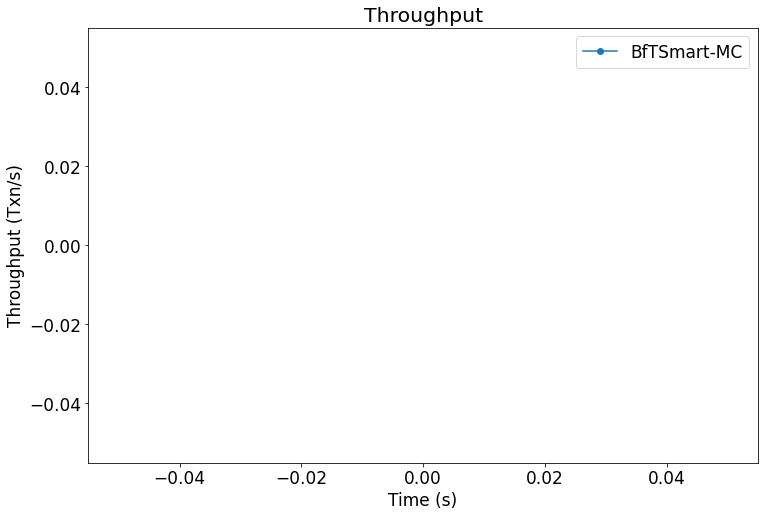

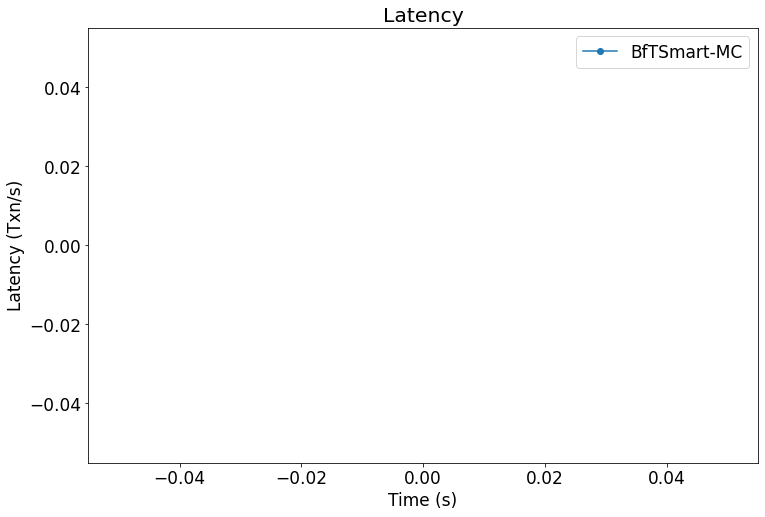

In [22]:
times_thputsDict = {}
times_latsDict = {}

for ip in clientIps[:1]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        times_thputsDict[times[i]] = thputs[i]
        times_latsDict[times[i]] = lats[i]
        

for ip in clientIps[1:]:    
    i = lines.index(ip)
    
    times ,thputs, lats = getTimesThputs('../Experiments/'+experiment+'/nohup_client_'+str(i)+'.out')
    
    
    for i in range(len(times)):
        
        if times[i] in times_thputsDict.keys():
            times_thputsDict[times[i]] += thputs[i]
            
        if times[i] in times_latsDict.keys():
            times_latsDict[times[i]] += lats[i]
    

PIK = '../Experiments/'+experiment+"/pickle.dat"

data = [times_thputsDict, times_latsDict]

with open(PIK, "wb") as f:
    pickle.dump(data, f)


data2 = []
with open(PIK, "rb") as f:
    data2 =  pickle.load(f)


dict1 = data2[0]
dict2 = data2[1]



times1 = np.array(list(dict1.keys()))
thputs = np.array(list(dict1.values()))

times2 = np.array(list(dict2.keys()))
lats = np.array(list(dict2.values()))

times1

import pylab as pl

pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], thputs[:], '-o', label='BfTSmart-MC')


pl.title(r'Throughput')


pl.xlabel('Time (s)')
pl.ylabel('Throughput (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out1.png', dpi = 150)
pl.show()




pl.figure(figsize = (12,8))
pl.rcParams.update({'font.size': 17})
pl.plot(times1[:], lats[:], '-o', label='BfTSmart-MC')


pl.title(r'Latency')


pl.xlabel('Time (s)')
pl.ylabel('Latency (Txn/s)')
pl.legend()
pl.savefig('../Experiments/'+experiment+'/out2.png', dpi = 150)
pl.show()

In [23]:
lats, np.average(lats[-85:-5])

/home/tejas/miniconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/tejas/miniconda3/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(array([], dtype=float64), nan)

echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-233-34-70.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-15-207-51-134.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-233-223-149.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-65-2-178-212.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-233-31-222.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-126-255-193.ap-south-1.compute.amazonaws.com:commands.s

echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-127-210-177.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-234-32-196.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-127-135-37.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-13-126-50-194.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-65-2-33-73.ap-south-1.compute.amazonaws.com:commands.sh
echo 3108 | sudo -S scp -o StrictHostKeyChecking=no -i /home/tejas/Documents/FKA.pem commands.sh ubuntu@ec2-15-206-91-92.ap-south-1.compute.amazonaws.com:commands.sh
